In [ ]:
import pandas as pd
from scipy import stats

In [ ]:
# Read the CSV file
df = pd.read_csv('health_dataset.csv')

In [ ]:
df = df.rename(columns={
    'High_cholestrol': 'High_cholesterol',
    'Fatique_syndrome': 'Fatigue_syndrome',
    'working_status ': 'working_status',
    'Work_hours ': 'Work_hours',
    'Fruit_,veg_con': 'Fruit_veg_con',
    'Tobaco_use': 'Tobacco_use',
    'Cannabies_use': 'Cannabis_use',
    'Health_utility_indx': 'Health_utility_index',
    'Health_region_ grouped': 'Health_region_grouped'
})

## 🧑‍🤝‍🧑📊 Demographic Data

**Gender**

**Marital_status**

In [ ]:
# Remove rows where Marital_status is 6 or 9
df = df[~df['Marital_status'].isin([6, 9])]

**Age**

In [ ]:
# Remove rows where Age is 1 → represents 12–17 years group
df = df[df['Age'] != 1]

**Edu_level**

In [ ]:
# Remove rows where Edu_level is 9 → Not stated
df = df[df['Edu_level'] != 9]

**working_status**

In [ ]:
# Step 1: Remove rows where working_status is 9 (missing)
df = df[df['working_status'] != 9].copy()  # <- Important to copy to avoid warning

# Step 2: Replace values safely using .loc
df.loc[:, 'working_status'] = df['working_status'].replace({
    1: 1,  # Full time -> Working (1)
    2: 1,  # Part time -> Working (1)
    6: 2   # Valid Skip -> Not working (2)
})

## 🧠📊 Behavioral Data

**Smoked**

In [ ]:
# Step 1: Remove rows where Smoked is 999 → missing value, or blank (NaN)
df = df[~df['Smoked'].isin([999])]
df = df[df['Smoked'].notna()].copy()  # remove NaN and avoid warning

# Step 2: Recode Smoked
# 996 → 2 = Non-Daily Smoker
# All other values → 1 = Daily Smoker
df.loc[:, 'Smoked'] = df['Smoked'].apply(lambda x: 2 if x == 996 else 1)

# Step 3: Ensure Smoked is integer
df['Smoked'] = df['Smoked'].astype(int)

**weekly_alcohol**

In [ ]:
# Step 1: Remove rows where weekly_alcohol is 999 → missing value
df = df[df['weekly_alcohol'] != 999].copy()

# Step 2: Recode weekly_alcohol
# 996 → 2 = Non-drinker
# All other values → 1 = Drinker
df.loc[:, 'weekly_alcohol'] = df['weekly_alcohol'].apply(lambda x: 2 if x == 996 else 1)

**Drug_use    |    Cannabis_use**

In [ ]:
# Create new variable 'any_substance_use'
# 1 = if any among Smoked, weekly_alcohol, Cannabis_use, Drug_use is 1
# 0 = otherwise (automatically handled by astype(int))

df['any_substance_use'] = (
    ((df['Smoked'] == 1) |
     (df['weekly_alcohol'] == 1) |
     (df['Cannabis_use'] == 1) |
     (df['Drug_use'] == 1))
    .astype(int)
)

# Count the number of respondents with and without any substance use
print("🔹 Count of 'any_substance_use':")
print(df['any_substance_use'].value_counts().sort_index())

🔹 Count of 'any_substance_use':
any_substance_use
0    46787
1    44428
Name: count, dtype: int64


##🎯 Target Data

**Stress_level**

In [ ]:
# Clean Stress_level:
# 1 to 5 → Valid responses (1 = Not stressed at all, 5 = Extreme stress) → Retain
# 7 and 8 → Represent missing or invalid responses → Remove

df = df[df['Stress_level'].isin([1, 2, 3, 4, 5])]

In [ ]:
# Add a column for cat_stress:
# Where 1 to 3: No stress
# Where 4 to 5: High stress

df['cat_stress'] = df['Stress_level'].apply(lambda x: 1 if x <= 3 else 2)

<ipython-input-16-7fc7265d1b06>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cat_stress'] = df['Stress_level'].apply(lambda x: 1 if x <= 3 else 2)


## 🩺🧬 Physical Health

**Sleep_apnea  |  High_BP  |  Fatigue_syndrome  |  High_cholesterol  |  Diabetic
 |  Respiratory_chronic_con  |  Musculoskeletal_con  |  Cardiovascular_con**

In [ ]:
# Clean health condition indicators
# 1 = Yes, 2 = No → Retain
# Other values = Invalid/missing → Remove (except for specific valid skip like Diabetic = 6)

df = df[
    # Sleep_apnea: Remove 7, 8 (invalid)
    df['Sleep_apnea'].isin([1, 2]) &

    # High_BP: Remove 7, 8 (invalid)
    df['High_BP'].isin([1, 2]) &

    # Fatigue_syndrome: Remove 7, 8 (invalid)
    df['Fatigue_syndrome'].isin([1, 2]) &

    # High_cholesterol: Remove 6, 7, 8 (invalid)
    df['High_cholesterol'].isin([1, 2]) &

    # Diabetic: Keep 1 = Diabetes, 2 = No Diabetes, 6 = Pre-diabetic → Remove 7, 8
    df['Diabetic'].isin([1, 2, 7]) &

    # Respiratory_chronic_con: Remove 9 (invalid)
    df['Respiratory_chronic_con'].isin([1, 2]) &

    # Musculoskeletal_con: Remove 6, 9 (invalid)
    df['Musculoskeletal_con'].isin([1, 2]) &

    # Cardiovascular_con: Remove 9 (invalid)
    df['Cardiovascular_con'].isin([1, 2])
]

In [ ]:
# Count physical health issues (value = 1 means "Yes")
# Diabetic is counted only if it's exactly 1 (exclude 6 = pre-diabetic)

# Ensure df is an independent copy before assigning new columns
df = df.copy()

df['physical_health_issues_count'] = (
    (df['Sleep_apnea'] == 1).astype(int) +
    (df['High_BP'] == 1).astype(int) +
    (df['High_cholesterol'] == 1).astype(int) +
    (df['Diabetic'] == 1).astype(int) +  # Only count diabetes, not pre-diabetic
    (df['Fatigue_syndrome'] == 1).astype(int) +
    (df['Respiratory_chronic_con'] == 1).astype(int) +
    (df['Musculoskeletal_con'] == 1).astype(int) +
    (df['Cardiovascular_con'] == 1).astype(int)
)
# Show the first few rows of the new column
print("🔹 Preview of physical_health_issues_count:")
print(df[['physical_health_issues_count']].head())

# Count how many respondents have 0, 1, 2, ... health issues
print("\n🔹 Count of respondents by number of physical health issues:")
print(df['physical_health_issues_count'].value_counts().sort_index())

# Summary statistics for the count column
print("\n🔹 Summary statistics of physical_health_issues_count:")
print(df['physical_health_issues_count'].describe())

🔹 Preview of physical_health_issues_count:
   physical_health_issues_count
0                             0
1                             2
2                             4
3                             2
5                             3

🔹 Count of respondents by number of physical health issues:
physical_health_issues_count
0    32805
1    19911
2    13217
3     7917
4     3789
5     1296
6      347
7       69
8        6
Name: count, dtype: int64

🔹 Summary statistics of physical_health_issues_count:
count    79357.000000
mean         1.188868
std          1.333673
min          0.000000
25%          0.000000
50%          1.000000
75%          2.000000
max          8.000000
Name: physical_health_issues_count, dtype: float64


In [ ]:
# Define the columns to retain
columns_to_keep = [
    'Gender',
    'Marital_status',
    'Age',
    'Edu_level',
    'Stress_level',
    'working_status',
    'Smoked',
    'weekly_alcohol',
    'Cannabis_use',
    'Drug_use',
    'any_substance_use',
    'Sleep_apnea',
    'High_BP',
    'High_cholesterol',
    'Diabetic',
    'Fatigue_syndrome',
    'Respiratory_chronic_con',
    'Musculoskeletal_con',
    'Cardiovascular_con',
    'physical_health_issues_count',
    'cat_stress'
]

# Keep only the specified columns
df = df[columns_to_keep]

In [ ]:
print(df.columns)
print(df.shape)
df.head(5)

Index(['Gender', 'Marital_status', 'Age', 'Edu_level', 'Stress_level',
       'working_status', 'Smoked', 'weekly_alcohol', 'Cannabis_use',
       'Drug_use', 'any_substance_use', 'Sleep_apnea', 'High_BP',
       'High_cholesterol', 'Diabetic', 'Fatigue_syndrome',
       'Respiratory_chronic_con', 'Musculoskeletal_con', 'Cardiovascular_con',
       'physical_health_issues_count', 'cat_stress'],
      dtype='object')
(79357, 21)


,Gender,Marital_status,Age,Edu_level,Stress_level,working_status,Smoked,weekly_alcohol,Cannabis_use,Drug_use,...,Sleep_apnea,High_BP,High_cholesterol,Diabetic,Fatigue_syndrome,Respiratory_chronic_con,Musculoskeletal_con,Cardiovascular_con,physical_health_issues_count,cat_stress
0,2,1,3,3,2,1,2,2,2,2,...,2,2,2,2,2,2,2,2,0,1
1,1,1,5,2,3,1,2,2,2,2,...,1,1,2,2,2,2,2,2,2,1
2,2,2,5,1,3,1,2,2,2,2,...,2,1,2,1,2,1,1,2,4,1
3,1,2,5,1,3,1,2,2,2,6,...,2,1,2,2,2,2,1,2,2,1
5,2,1,5,3,4,1,2,1,2,6,...,2,2,2,2,1,2,1,1,3,2


In [ ]:
# Check for missing data in each column
missing_data = df.isnull().sum()

# Show only columns with at least 1 missing value
missing_data = missing_data[missing_data > 0]

print("🔍 Columns with missing values:")
print(missing_data)

🔍 Columns with missing values:
Series([], dtype: int64)


#EDA

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

## EDA (Distribution)

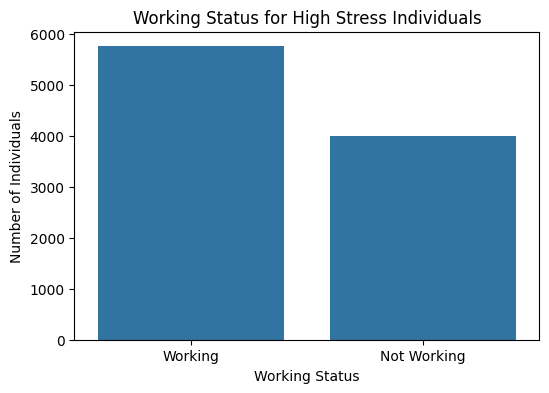

In [ ]:
# prompt: Can u draw a bar chart that show working status with cat_stress = high stress without number labels and percentage, and  without linestyle

# Filter data for high stress
df_high_stress = df[df['cat_stress'] == 2].copy()

# Get value counts for working_status in the filtered data
working_status_counts = df_high_stress['working_status'].value_counts()

# Map working status codes to descriptive labels for plotting
working_status_labels = {1: 'Working', 2: 'Not Working'}
labels = [working_status_labels[i] for i in working_status_counts.index]

# Create the bar plot
plt.figure(figsize=(6, 4))
sns.barplot(x=labels, y=working_status_counts.values, errorbar=None) # Removed errorbar for no line style
plt.title('Working Status for High Stress Individuals')
plt.xlabel('Working Status')
plt.ylabel('Number of Individuals')
plt.show()

<ipython-input-19-c1c60e323511>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Stress_level', data=df, palette='viridis', order=sorted(df['Stress_level'].unique()))


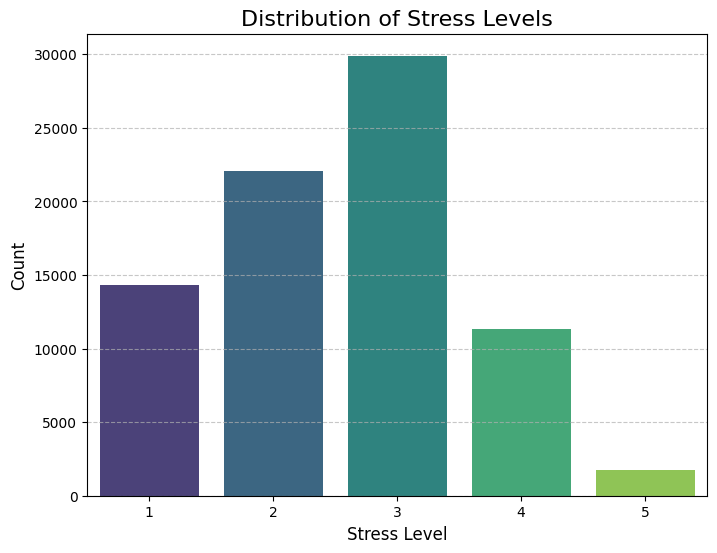

<ipython-input-19-c1c60e323511>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='physical_health_issues_count', data=df, palette='plasma', order=sorted(df['physical_health_issues_count'].unique()))


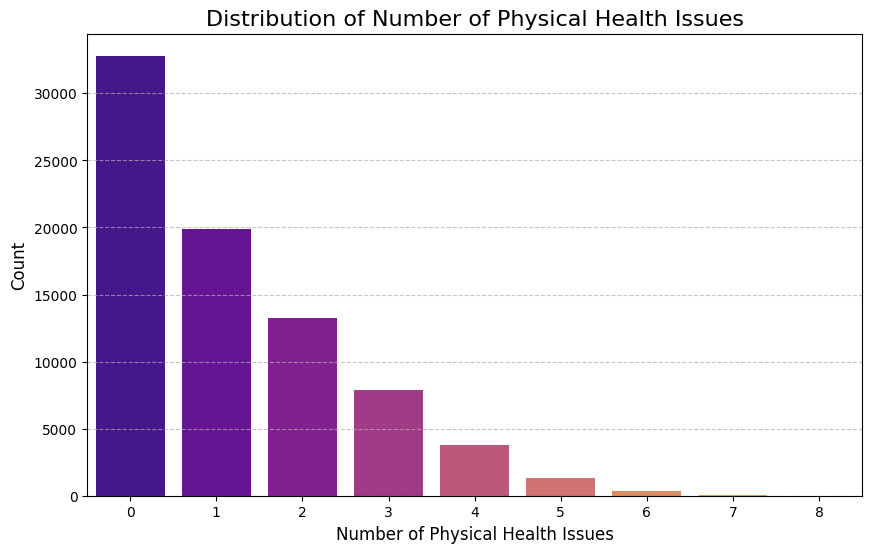

In [ ]:
# Distribution of Stress Levels
plt.figure(figsize=(8, 6))
sns.countplot(x='Stress_level', data=df, palette='viridis', order=sorted(df['Stress_level'].unique()))
plt.title('Distribution of Stress Levels', fontsize=16)
plt.xlabel('Stress Level', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Distribution of the number of physical health issues
plt.figure(figsize=(10, 6))
sns.countplot(x='physical_health_issues_count', data=df, palette='plasma', order=sorted(df['physical_health_issues_count'].unique()))
plt.title('Distribution of Number of Physical Health Issues', fontsize=16)
plt.xlabel('Number of Physical Health Issues', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

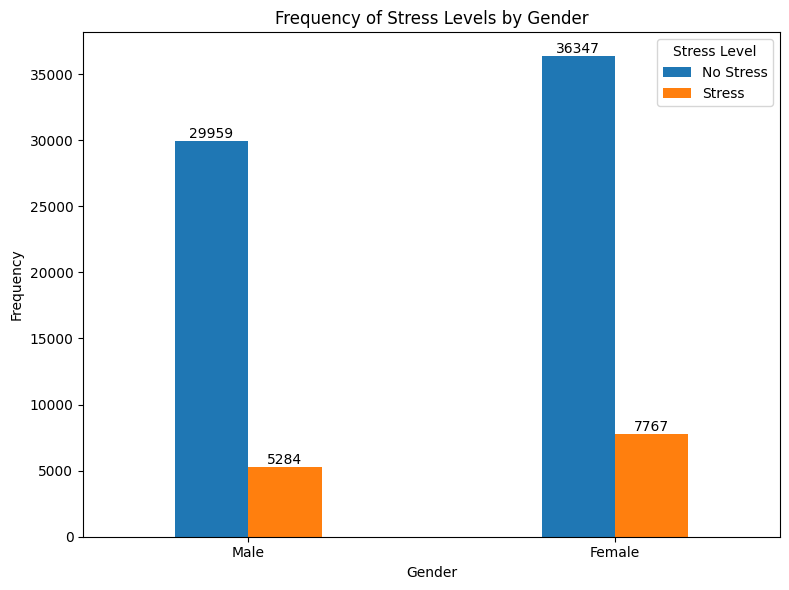

In [ ]:
# Group by Gender and cat_stress, and count the occurrences
stress_gender_counts = df.groupby(['Gender', 'cat_stress']).size().unstack(fill_value=0)

# Rename columns for better understanding
stress_gender_counts.columns = ['No Stress', 'Stress']

# Plotting the bar chart
fig, ax = plt.subplots(figsize=(8, 6))

stress_gender_counts.plot(kind='bar', ax=ax, width=0.4)

# Set title and labels
ax.set_title('Frequency of Stress Levels by Gender')
ax.set_xlabel('Gender')
ax.set_ylabel('Frequency')
ax.set_xticks(range(len(stress_gender_counts.index)))
ax.set_xticklabels(['Male' if g == 1 else 'Female' for g in stress_gender_counts.index], rotation=0)
ax.legend(title='Stress Level')

# Add value labels on top of bars
for container in ax.containers:
    ax.bar_label(container)

plt.tight_layout()
plt.show()


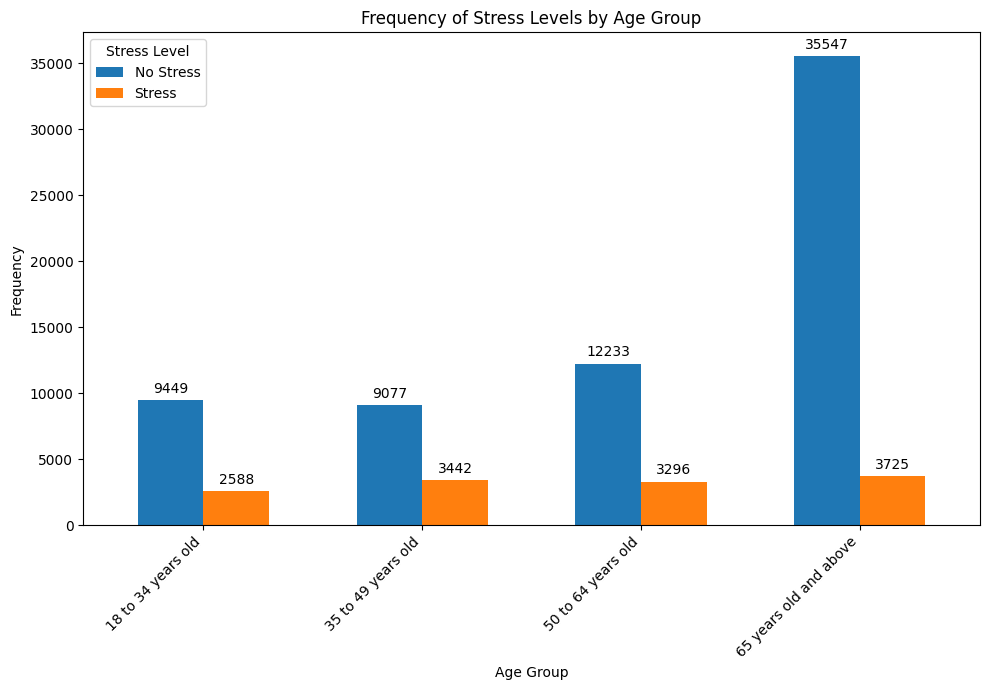

In [ ]:
# Map numerical Age values to descriptive labels
age_labels = {
    2: '18 to 34 years old',
    3: '35 to 49 years old',
    4: '50 to 64 years old',
    5: '65 years old and above'
}
df['Age_Group'] = df['Age'].map(age_labels)

# Filter out rows where Age is not in the defined age_labels (i.e., Age=1 or others not mapped)
df_filtered = df[df['Age_Group'].notna()].copy()

# Group by Age_Group and cat_stress, and count the occurrences
stress_age_counts = df_filtered.groupby(['Age_Group', 'cat_stress']).size().unstack(fill_value=0)

# Rename stress category columns for clarity
stress_age_counts.columns = ['No Stress', 'Stress']

# Reorder the columns to match the x-axis order
stress_age_counts = stress_age_counts.reindex([
    '18 to 34 years old',
    '35 to 49 years old',
    '50 to 64 years old',
    '65 years old and above'
])


# Plotting the bar chart
fig, ax = plt.subplots(figsize=(10, 7))

stress_age_counts.plot(kind='bar', ax=ax, width=0.6)

# Set title and labels
ax.set_title('Frequency of Stress Levels by Age Group')
ax.set_xlabel('Age Group')
ax.set_ylabel('Frequency')
ax.set_xticklabels(stress_age_counts.index, rotation=45, ha='right') # Rotate labels for readability
ax.legend(title='Stress Level')

# Add value labels on top of bars
for container in ax.containers:
    ax.bar_label(container, fmt='%d', padding=3) # Use fmt='%d' for integer labels, padding to prevent overlap

plt.tight_layout() # Adjust layout to prevent labels overlapping
plt.show()

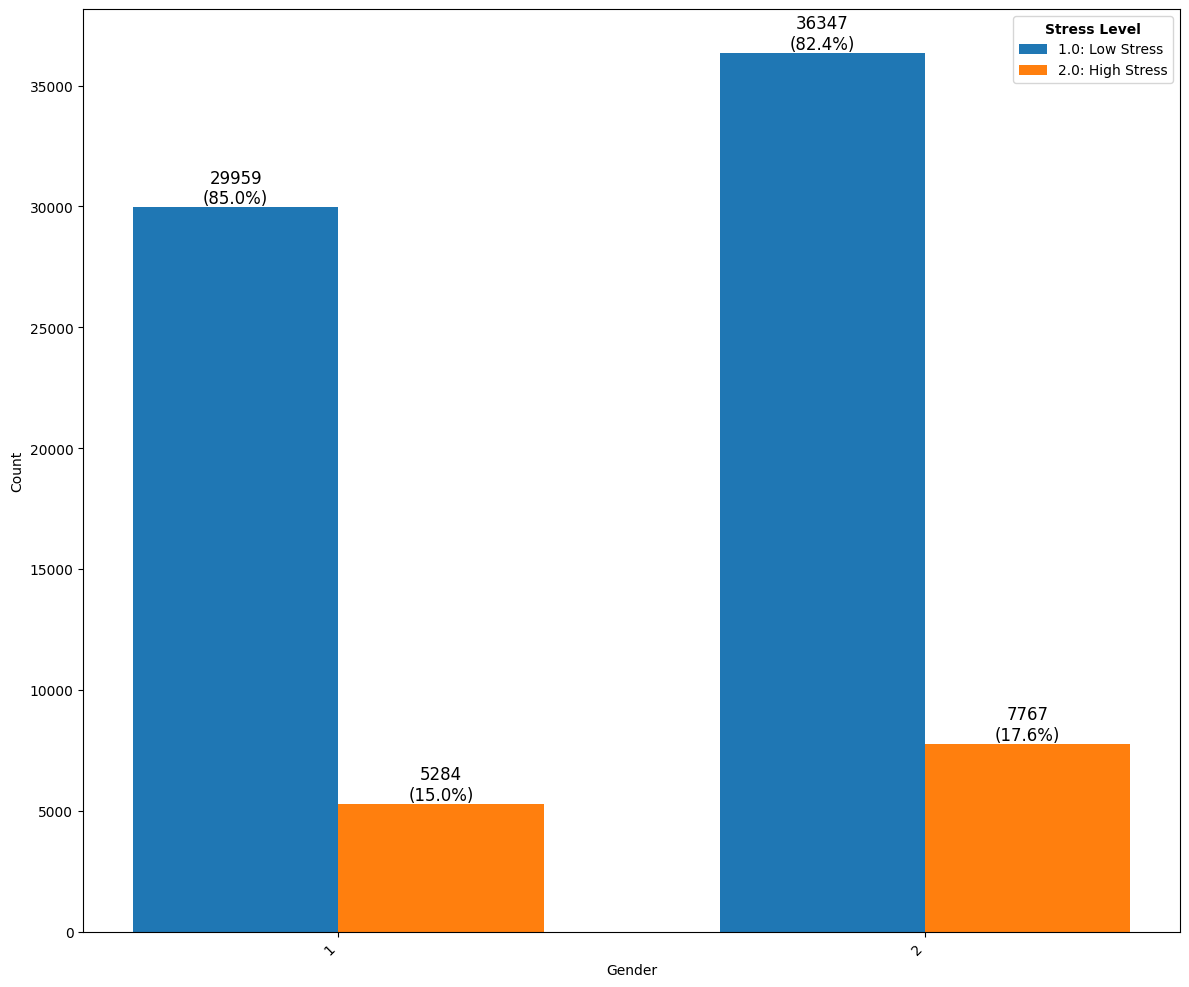

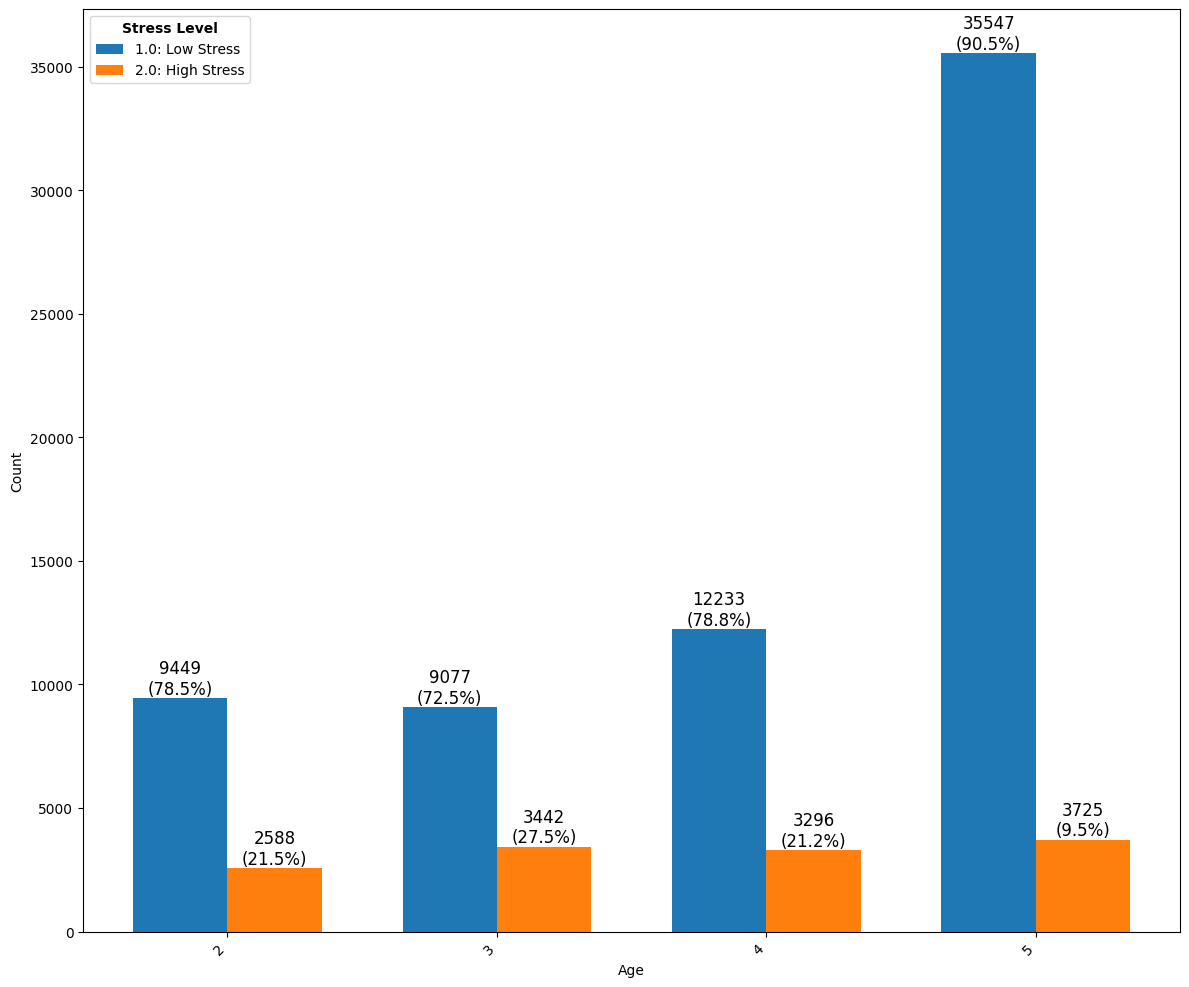

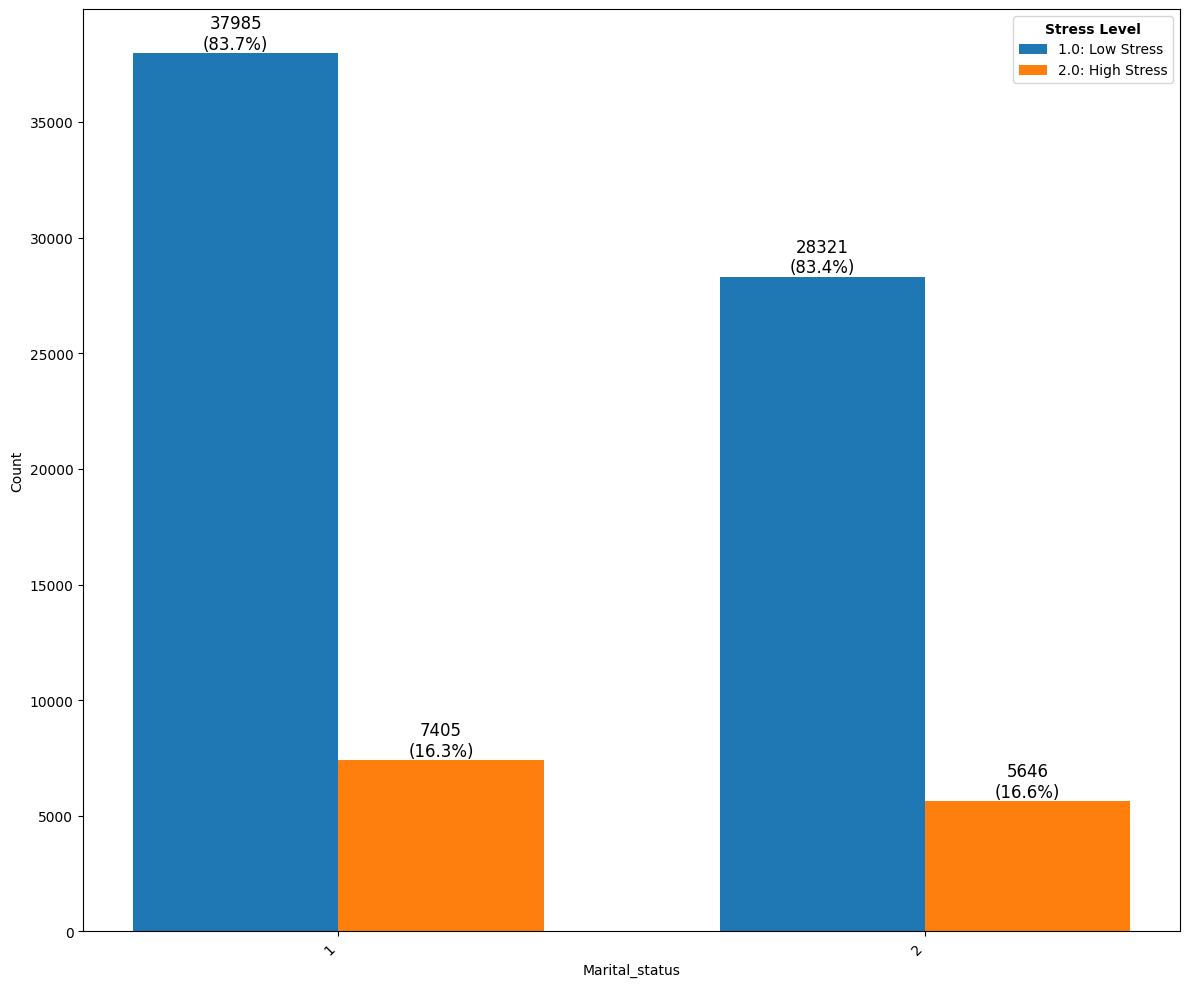

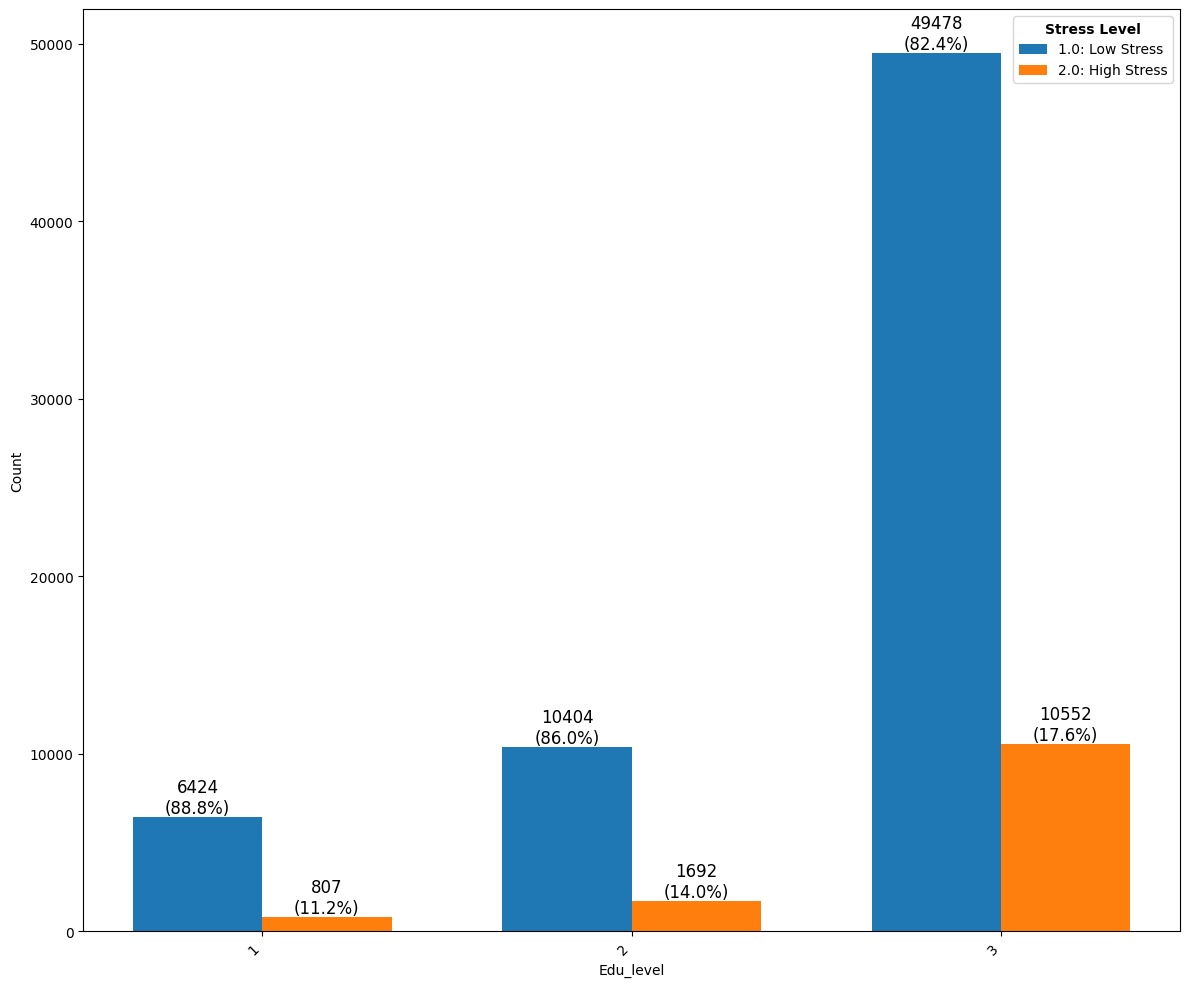

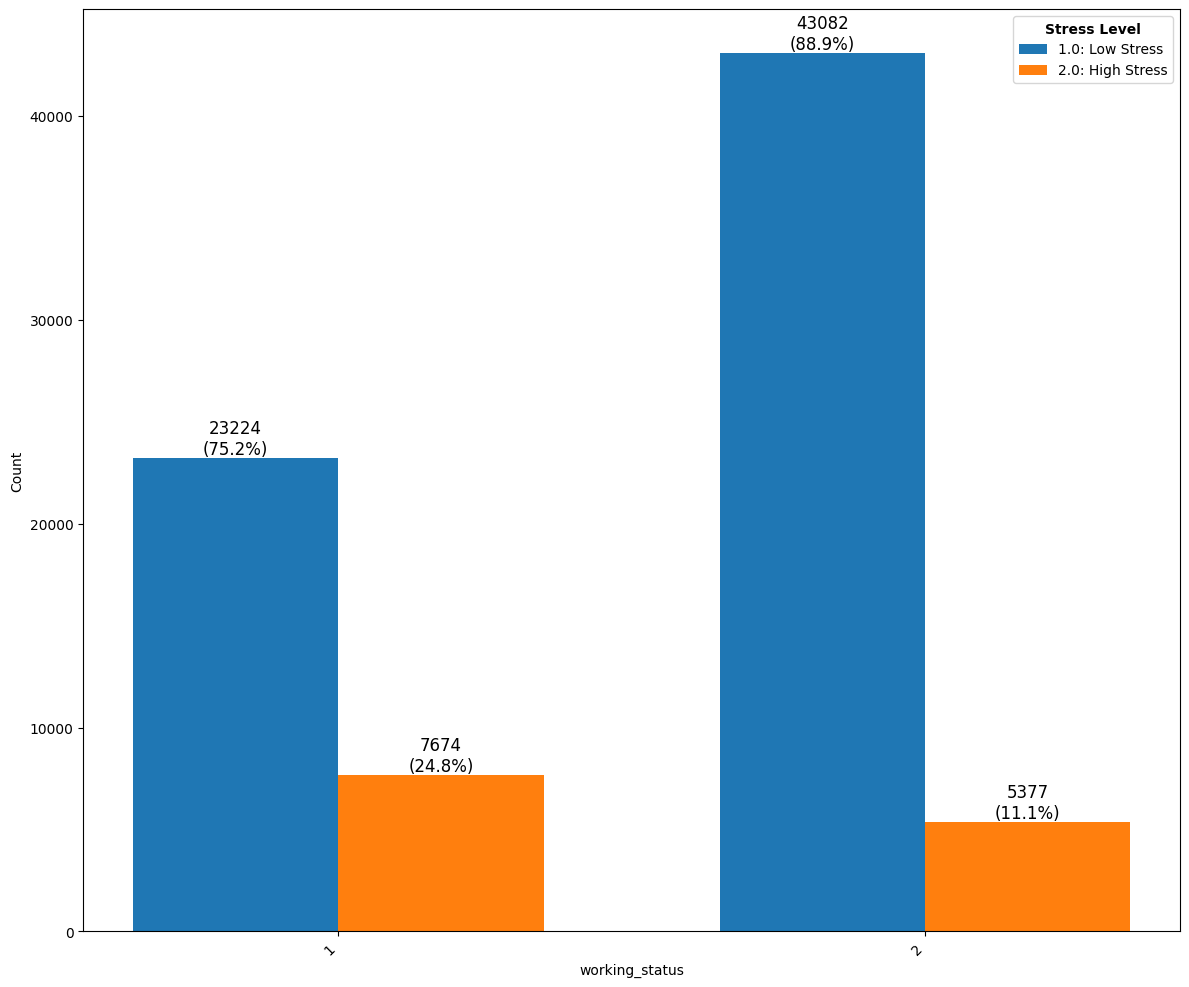

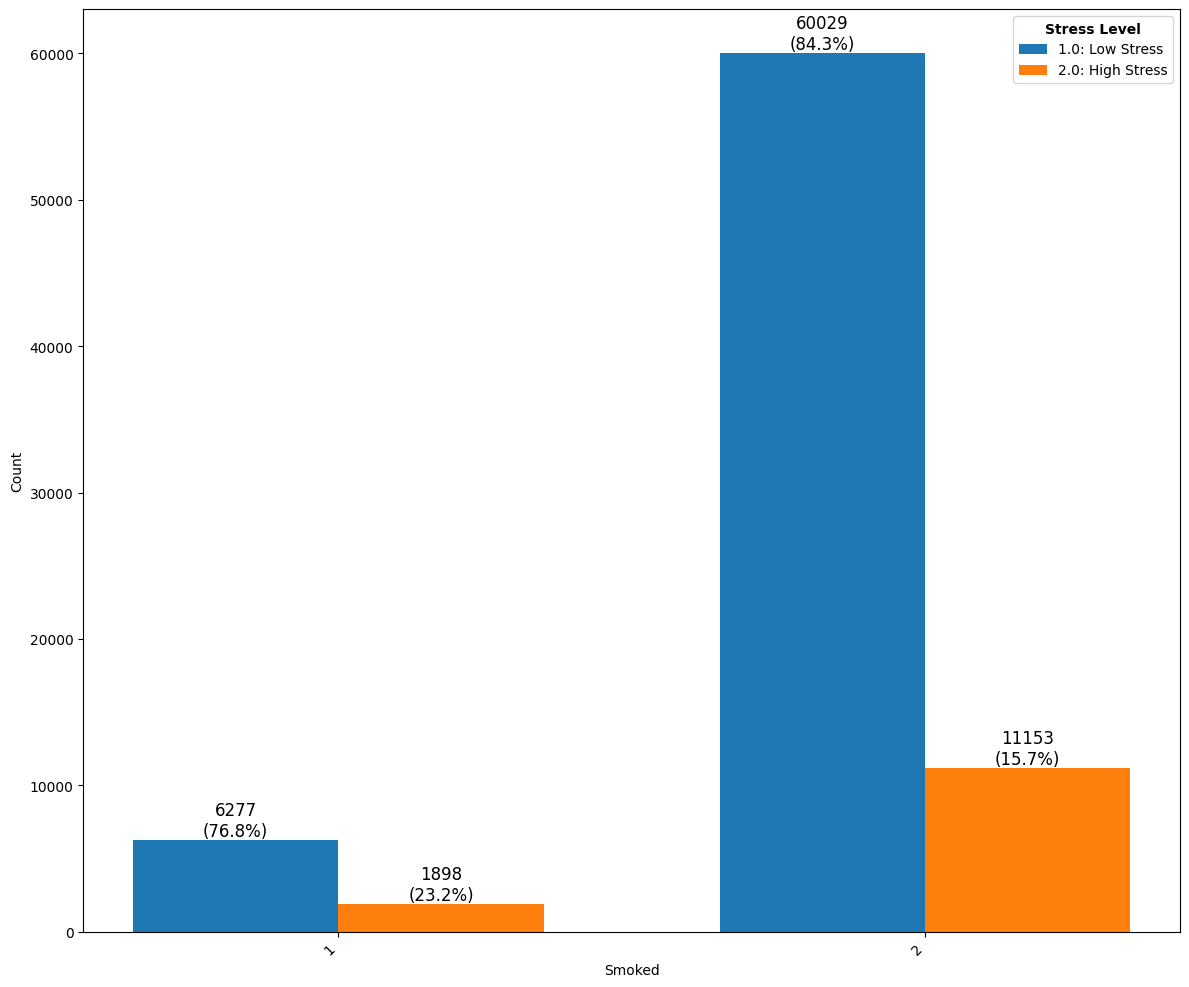

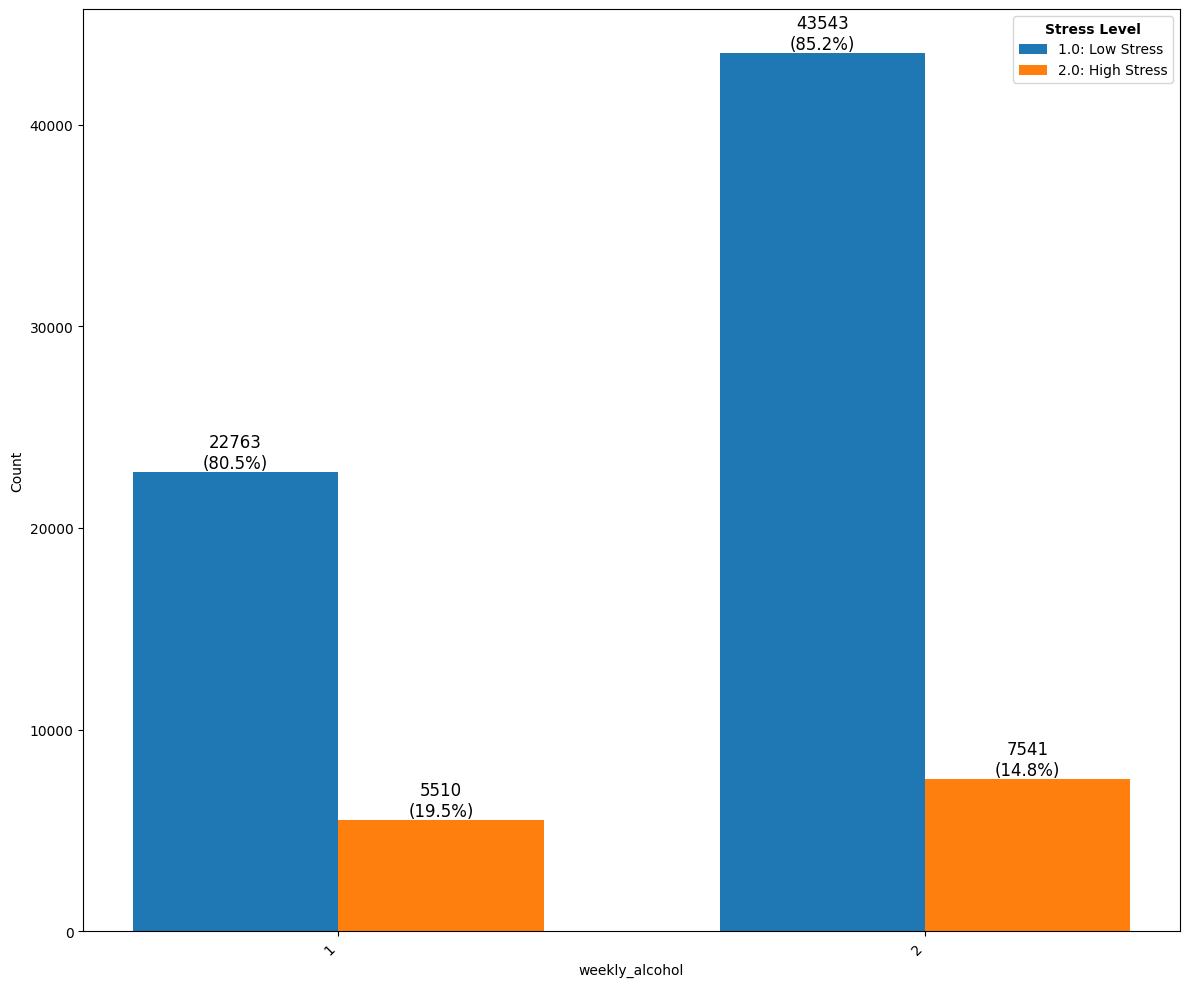

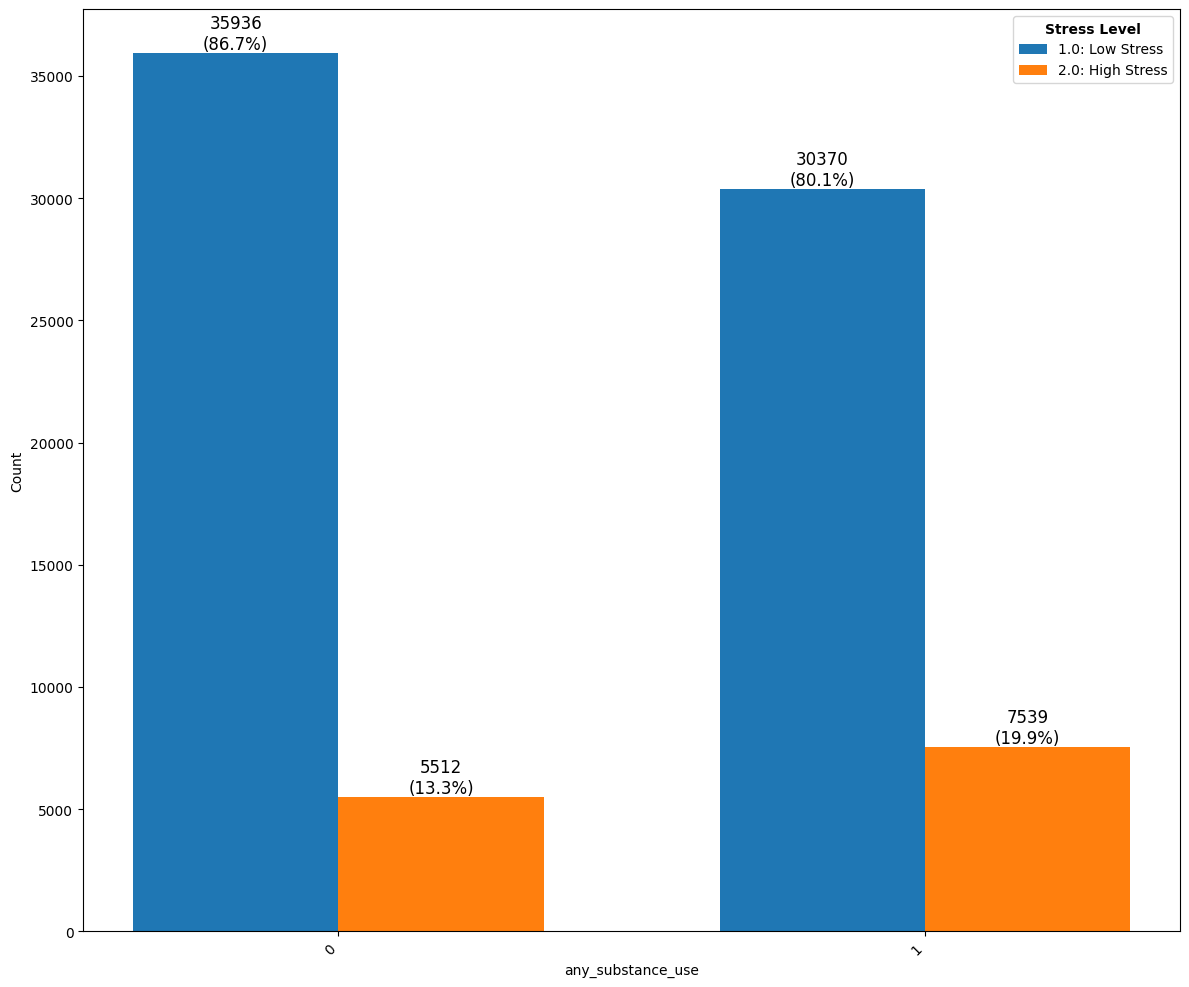

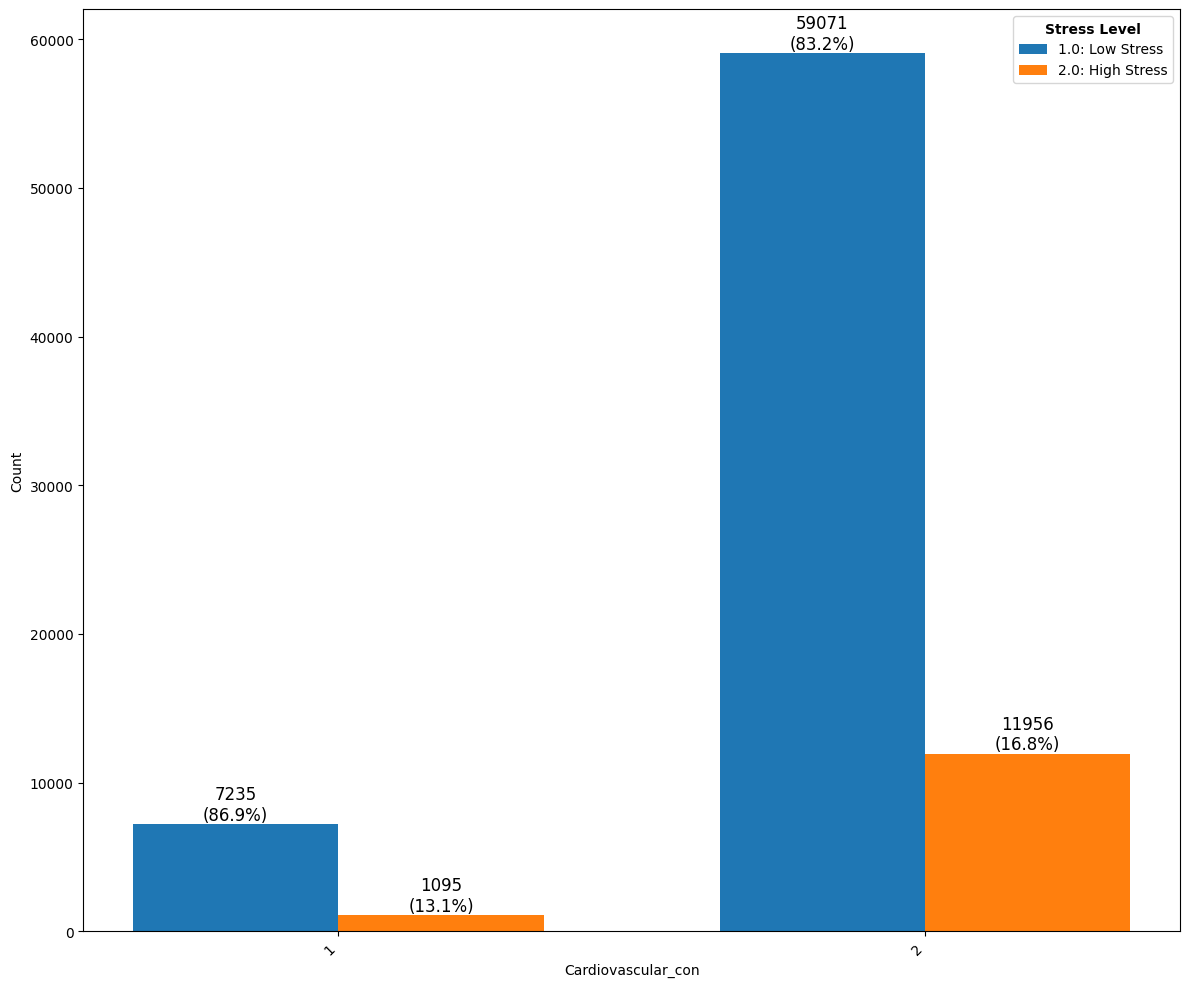

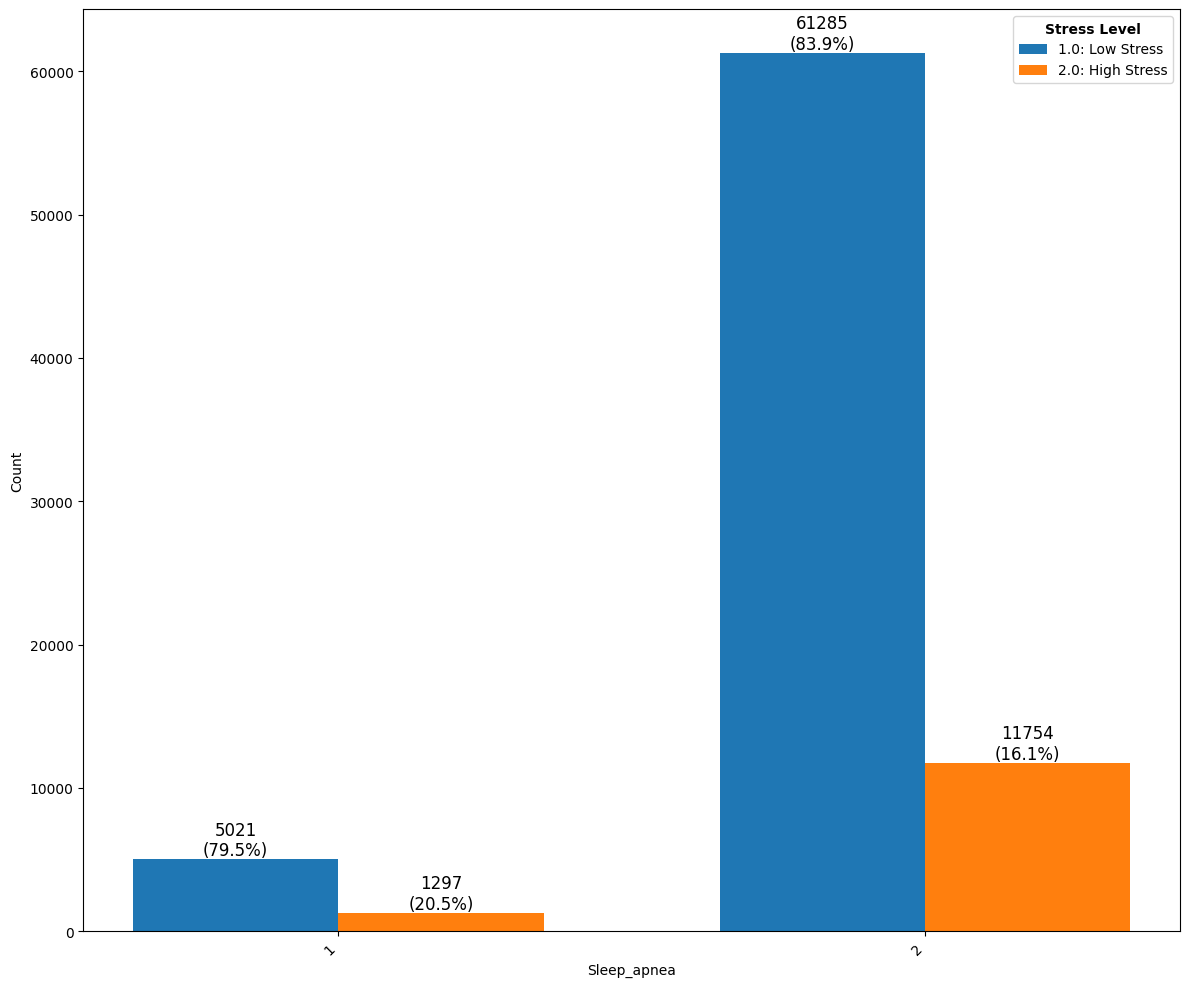

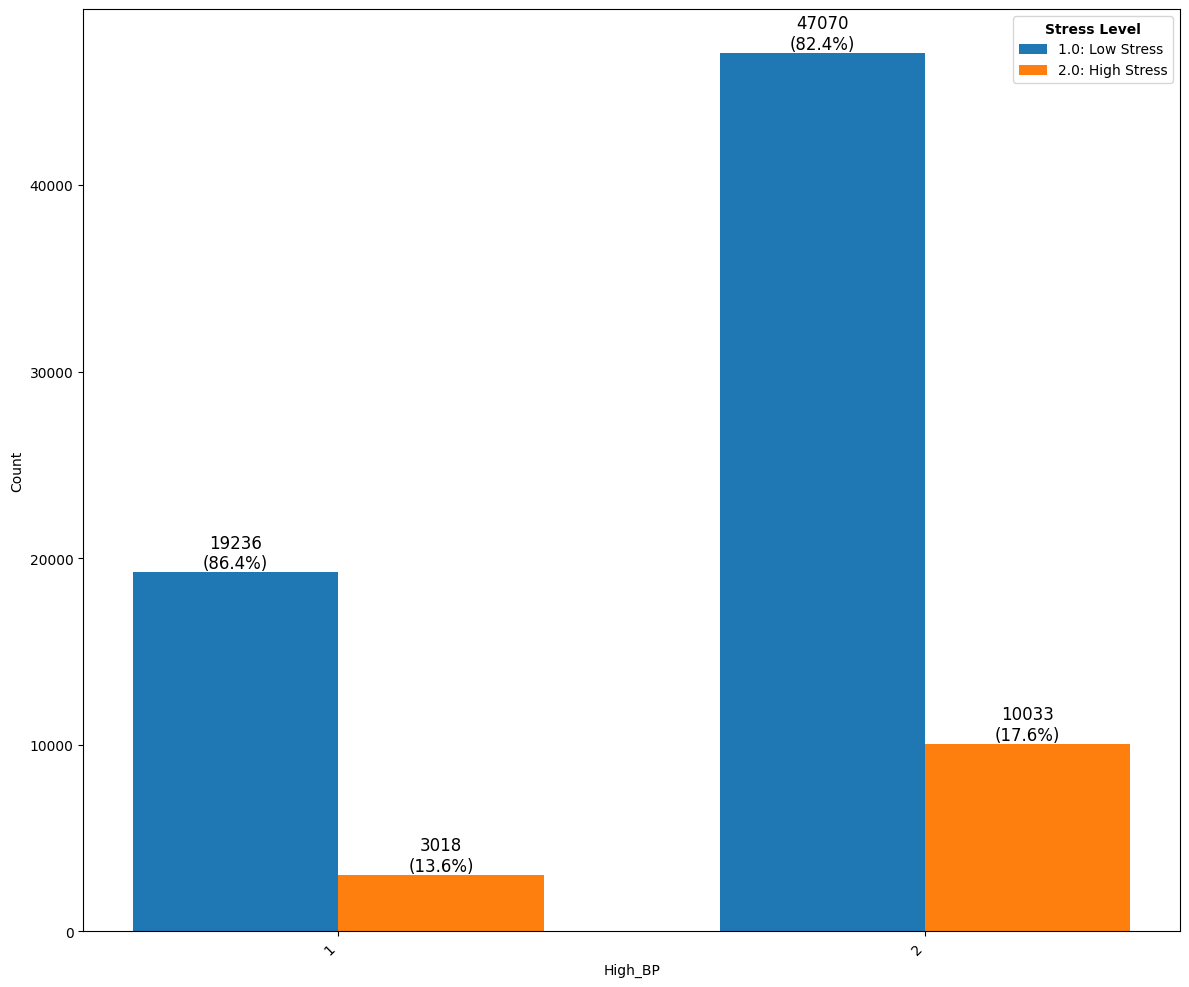

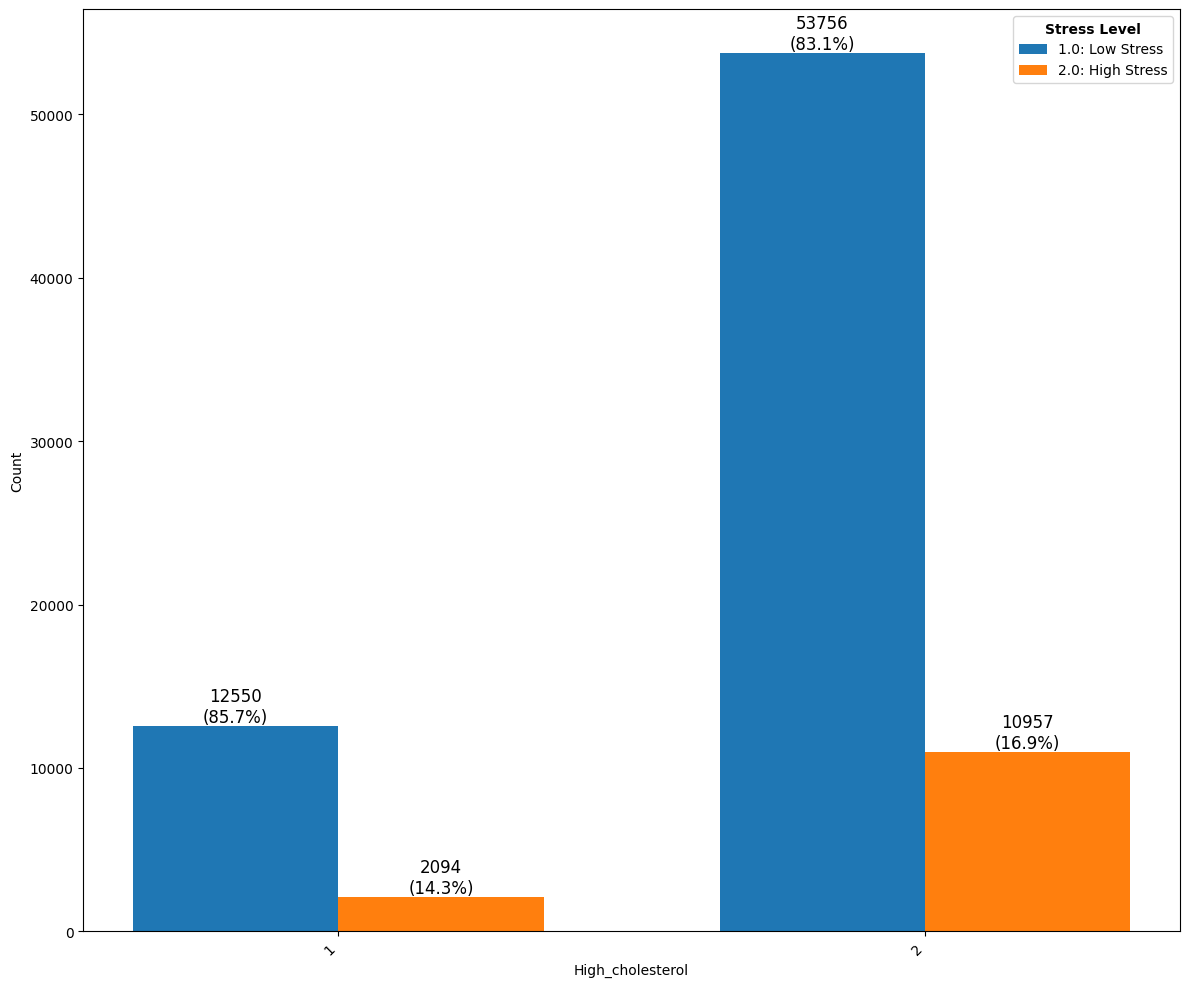

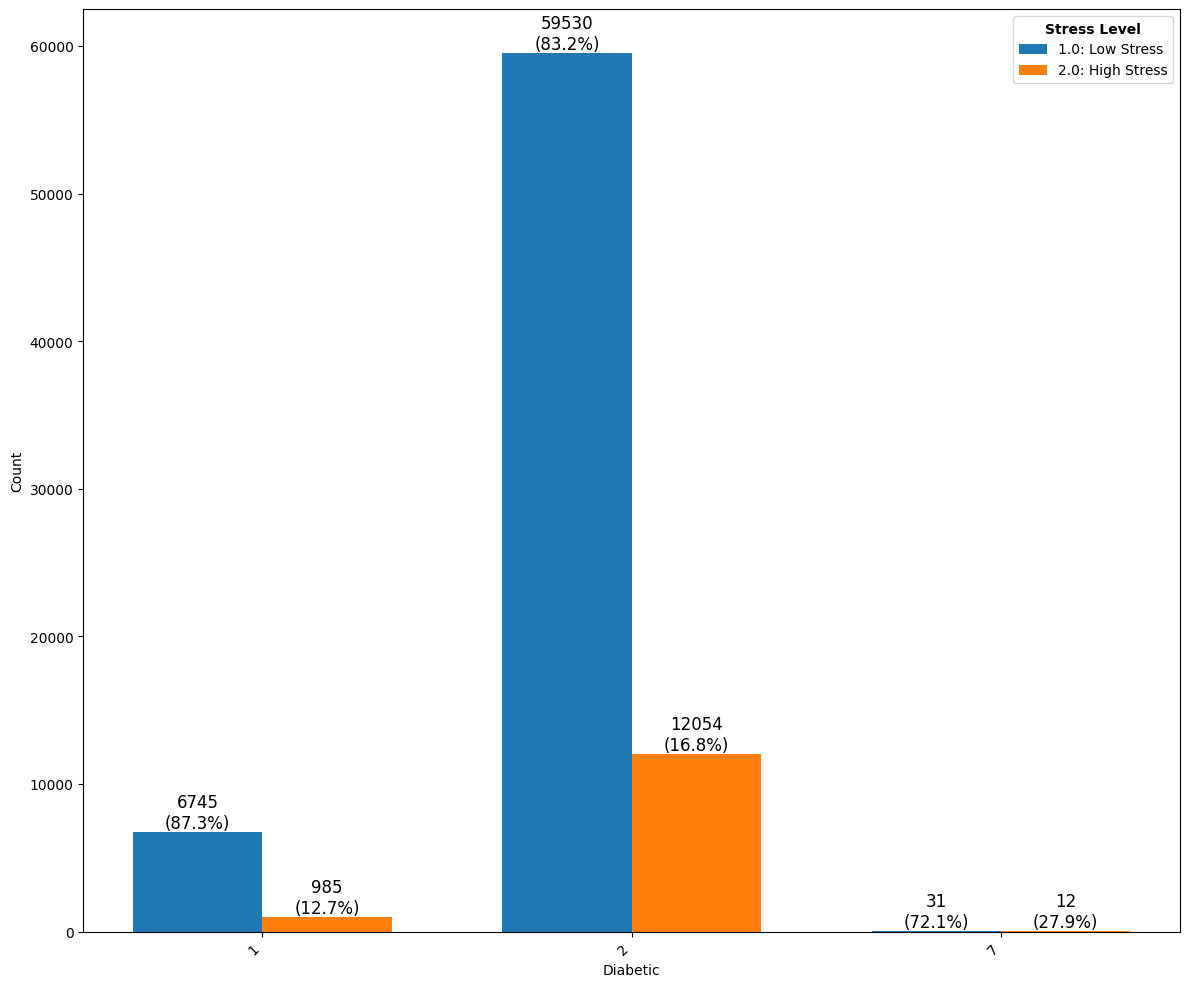

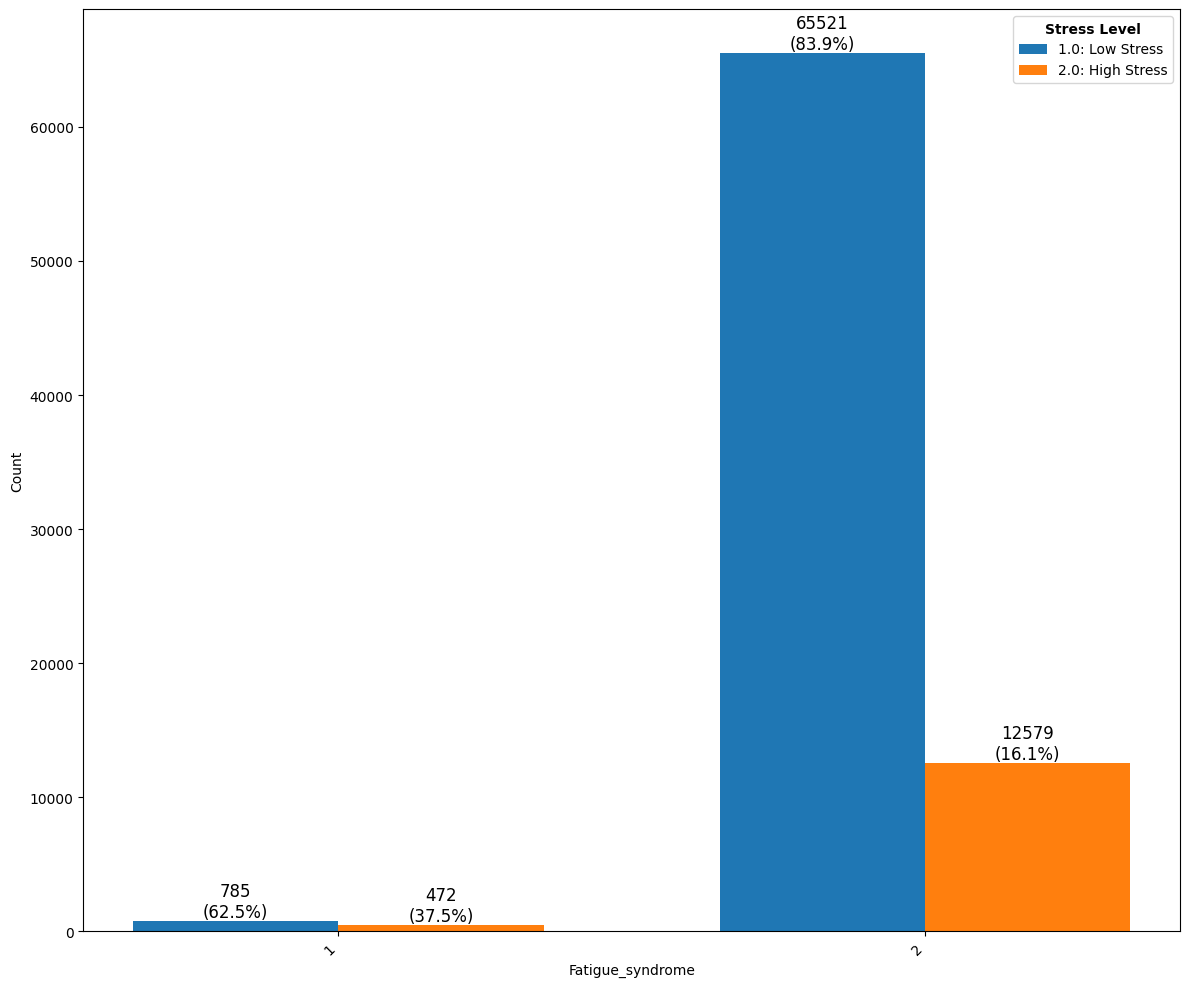

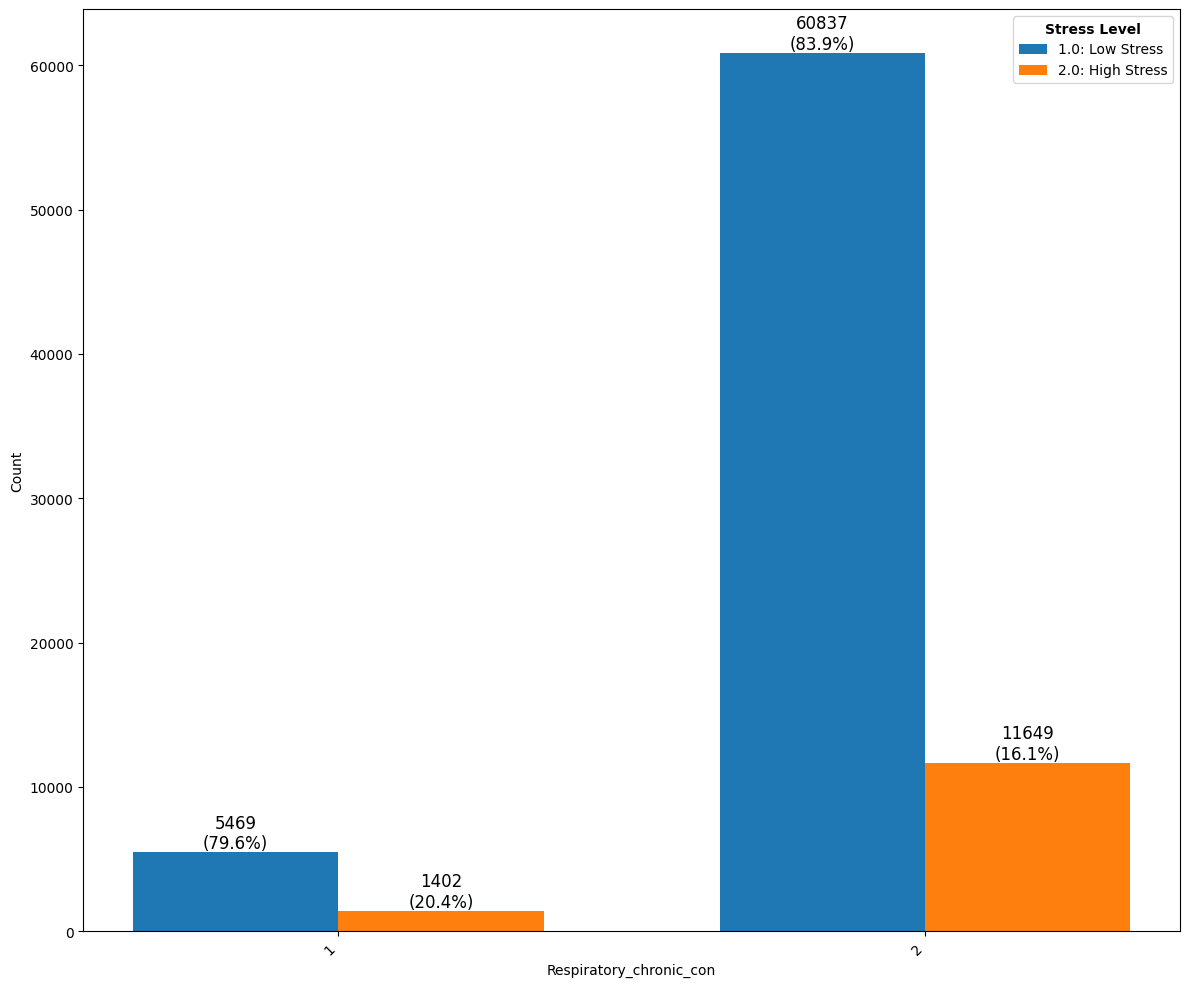

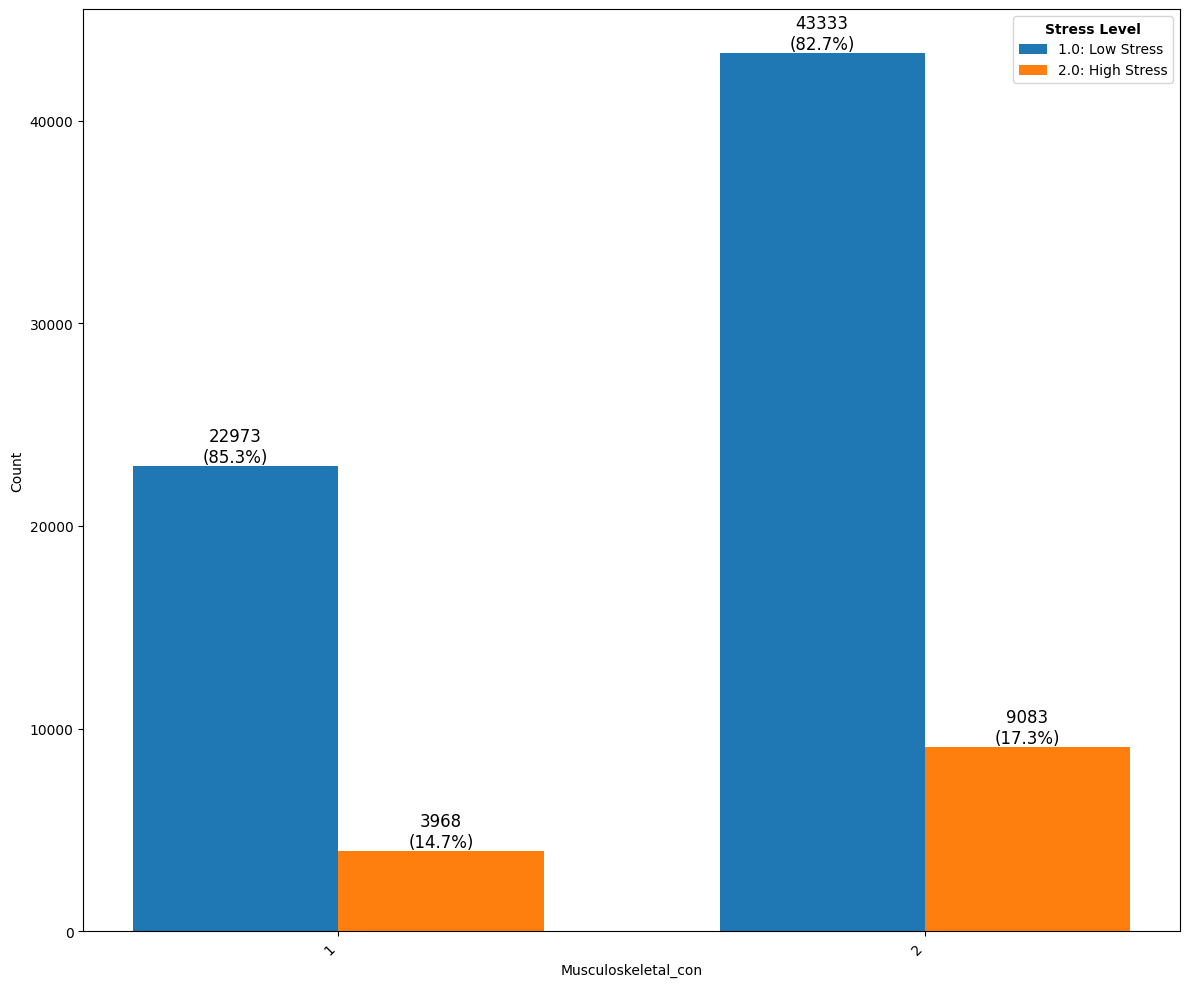

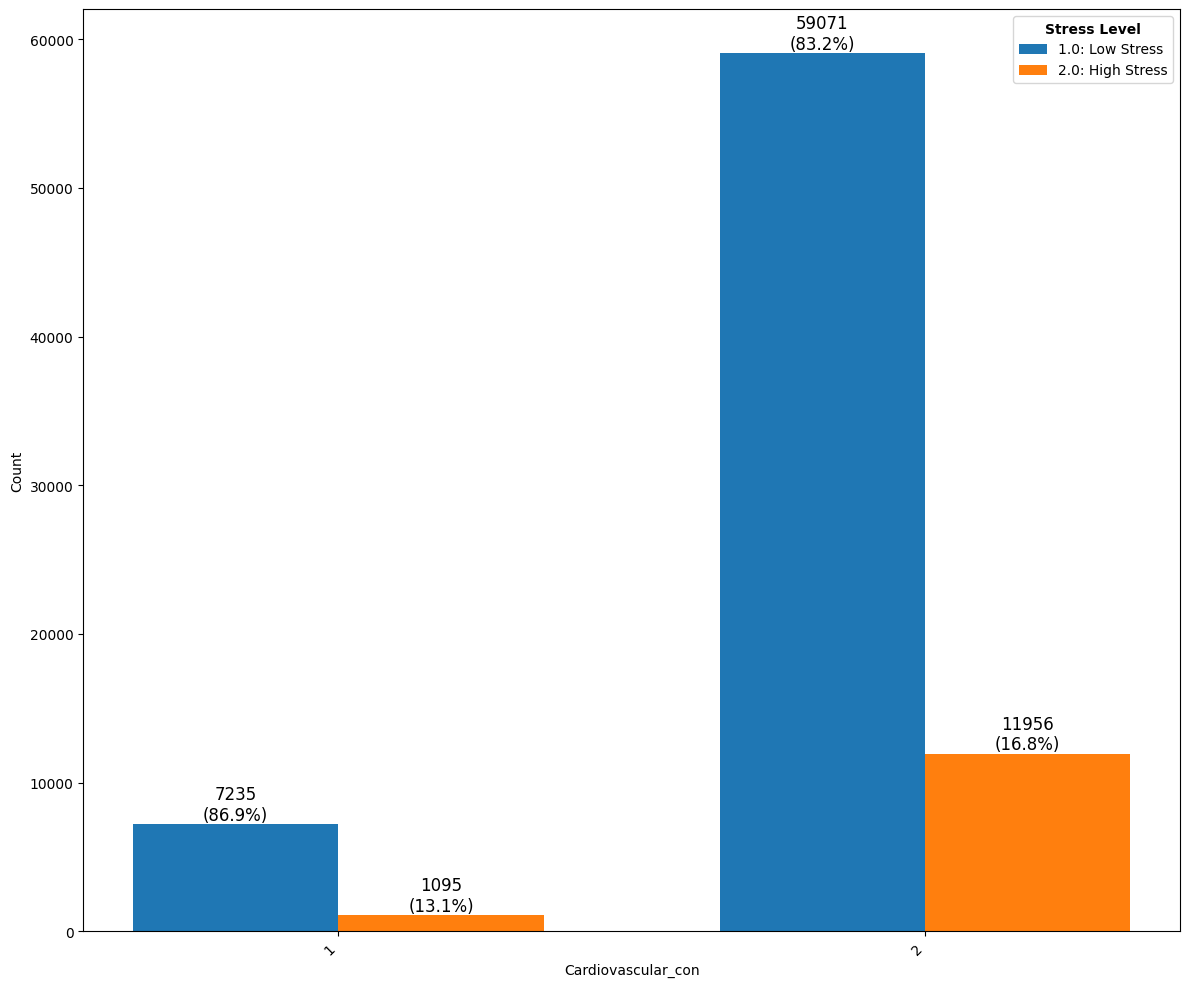

In [ ]:
import numpy as np

# def plot_grouped_bar_with_percentage(df, secondary_variable, xlabel, legend_label):
#   # Map Diabetes values to 'Low Stress' (1) and 'High Stress' (2)
#   target_variable = 'cat_stress'
#   value_counts = df[target_variable].value_counts()

#   # Calculate the percentage for 'Low Stress' (1) and 'High Stress' (2) in 'cat_stress'
#   total_count = len(df)
#   percentage_values = (value_counts / total_count) * 100
#   percentage_values = percentage_values.reindex([1, 2])  # Ensure both 1 and 2 are included
#   value_counts = value_counts.reindex([1.0, 2.0])  # Exclude Missing category

#   # Create labels with percentages for x-axis
#   new_labels = [f'Low Stress ({percentage_values[1]:.1f}%)', f'High Stress ({percentage_values[2]:.1f}%)']


#   # Count the frequency of A values for each category in C (No and Yes)
#   freq_A = df.groupby(target_variable)[secondary_variable].value_counts().unstack(fill_value=0)

#   # Set positions for the bars on the x-axis
#   x = np.arange(len(freq_A))  # Number of categories in C (No and Yes)

#   # Bar width based on the number of category of dependent column
#   category_counts = df[secondary_variable].nunique()
#   if category_counts <= 2:
#       bar_width = 0.35
#       font_size = 12
#   elif category_counts == 3:
#       bar_width = 0.25
#       font_size = 10
#   elif category_counts == 4:
#       bar_width = 0.2
#       font_size = 10
#   else:
#       bar_width = 0.07
#       font_size = 8

#   # Calculate the total count of A within each category of C
#   total_per_group = freq_A.sum(axis=1)  # Total count of A for each category in C

#   # Calculate the percentage for each value of A within each group (C = Yes/No)
#   percentage_A = freq_A.div(total_per_group, axis=0) * 100

#   # Create the plot
#   fig, ax = plt.subplots(figsize=(10, 10))

#   # Plot bars for column_a based on column_c
#   for idx, col in enumerate(freq_A.columns):
#       bars = ax.bar(x + (idx - (len(freq_A.columns) - 1) / 2) * bar_width,
#                     freq_A[col], bar_width, label=f'{target_variable}={col}')

#       # Adding percentage text above each bar
#       for i, bar in enumerate(bars):
#           height = bar.get_height()
#           # Get the percentage for this bar
#           group = freq_A.index[i]
#           frequency = freq_A.loc[group, col]
#           percentage = percentage_A.loc[group, col]

#           percentage = percentage_A.loc[group, col]
#           ax.text(bar.get_x() + bar.get_width() / 2, height + 0.1,
#                   f'{int(frequency)}\n({percentage:.1f}%)', ha='center', va='bottom', fontsize=font_size)


#   # Add labels, title, and legend
#   ax.set_xlabel('Stress Level')
#   ax.set_ylabel('')
#   ax.set_title('')
#   ax.set_xticks(x)
#   ax.set_xticklabels(new_labels)  # Custom labels for C (0 -> 'No', 1 -> 'Yes')
#   ax.legend(title= xlabel, labels= legend_label, title_fontproperties={'weight':'bold'})

#   # Show the plot
#   # plt.title(f'{age_group_label}')
#   plt.tight_layout()
#   plt.show()

# plot_grouped_bar_with_percentage(df,'Marital_status', 'Marital_status', ['Married', 'Single'])
# plot_grouped_bar_with_percentage(df,'Edu_level', 'Edu_level', ['Less than secondary school graduation', 'Secondary school graduation, no post-secondary education', 'Post-secondary certificate/diploma /university degree'])
# plot_grouped_bar_with_percentage(df,'working_status', 'working_status', ['Working', 'Not Working'])
# plot_grouped_bar_with_percentage(df,'Smoked', 'Smoked', ['Yes', 'No'])
# plot_grouped_bar_with_percentage(df,'weekly_alcohol', 'weekly_alcohol', ['Yes', 'No'])
# # plot_grouped_bar_with_percentage(df,'Cannabis_use', 'Cannabis_use', ['Yes', 'No'])
# # plot_grouped_bar_with_percentage(df,'Drug_use', 'Drug_use', ['Yes', 'No'])
# plot_grouped_bar_with_percentage(df,'any_substance_use', 'any_substance_use', ['No', 'Yes'])
# plot_grouped_bar_with_percentage(df,'Cardiovascular_con', 'Cardiovascular_con', ['Yes', 'No'])
# plot_grouped_bar_with_percentage(df,'Sleep_apnea', 'Sleep_apnea', ['Yes', 'No'])
# plot_grouped_bar_with_percentage(df,'High_BP', 'High_BP', ['Yes', 'No'])
# plot_grouped_bar_with_percentage(df,'High_cholesterol', 'High_cholesterol', ['Yes', 'No'])
# plot_grouped_bar_with_percentage(df,'Diabetic', 'Diabetic', ['Yes', 'No', 'pre-diabetic'])
# plot_grouped_bar_with_percentage(df,'Fatigue_syndrome', 'Fatigue_syndrome', ['Yes', 'No'])
# plot_grouped_bar_with_percentage(df,'Respiratory_chronic_con', 'Respiratory_chronic_con', ['Yes', 'No'])
# plot_grouped_bar_with_percentage(df,'Musculoskeletal_con', 'Musculoskeletal_con', ['Yes', 'No'])
# plot_grouped_bar_with_percentage(df,'Cardiovascular_con', 'Cardiovascular_con', ['Yes', 'No'])
# # physical_health_issues_count

def plot_grouped_bar_with_percentage_reversed(df, primary_variable, xlabel, legend_label):
    # 'cat_stress' becomes the variable shown as bar categories (the legend)
    target_variable = 'cat_stress'

    # Count how many respondents fall into each (primary_variable, cat_stress) group
    freq = df.groupby(primary_variable)[target_variable].value_counts(dropna=False).unstack(fill_value=0)

    # Ensure the order of 'Low Stress' (1) and 'High Stress' (2)
    freq = freq.reindex(columns=[1.0, 2.0], fill_value=0)

    # Compute total responses per group
    total_per_group = freq.sum(axis=1)
    percentage = freq.div(total_per_group, axis=0) * 100

    # Set up bar positions
    x = np.arange(len(freq.index))  # Groups for primary variable
    category_count = freq.shape[1]

    if category_count <= 2:
        bar_width = 0.35
        font_size = 12
    elif category_count == 3:
        bar_width = 0.25
        font_size = 10
    elif category_count == 4:
        bar_width = 0.2
        font_size = 10
    else:
        bar_width = 0.07
        font_size = 8

    # Plot setup
    fig, ax = plt.subplots(figsize=(12, 10))

    for idx, col in enumerate(freq.columns):
        bars = ax.bar(x + (idx - (category_count - 1) / 2) * bar_width,
                      freq[col], bar_width, label=f'{col}: {"Low Stress" if col == 1.0 else "High Stress"}')

        for i, bar in enumerate(bars):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width() / 2, height + 0.1,
                    f'{int(freq.iloc[i, idx])}\n({percentage.iloc[i, idx]:.1f}%)',
                    ha='center', va='bottom', fontsize=font_size)

    # Axis and labels
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Count')
    ax.set_xticks(x)
    ax.set_xticklabels(freq.index, rotation=45, ha='right')
    ax.legend(title='Stress Level', title_fontproperties={'weight':'bold'})

    plt.tight_layout()
    plt.show()

plot_grouped_bar_with_percentage_reversed(df,'Gender', 'Gender', ['Male', 'Female'])
plot_grouped_bar_with_percentage_reversed(df,'Age', 'Age', ['2', '3', '4', '5'])
plot_grouped_bar_with_percentage_reversed(df,'Marital_status', 'Marital_status', ['Married', 'Single'])
plot_grouped_bar_with_percentage_reversed(df,'Edu_level', 'Edu_level', ['Less than secondary school graduation', 'Secondary school graduation, no post-secondary education', 'Post-secondary certificate/diploma /university degree'])
plot_grouped_bar_with_percentage_reversed(df,'working_status', 'working_status', ['Working', 'Not Working'])
plot_grouped_bar_with_percentage_reversed(df,'Smoked', 'Smoked', ['Yes', 'No'])
plot_grouped_bar_with_percentage_reversed(df,'weekly_alcohol', 'weekly_alcohol', ['Yes', 'No'])
# plot_grouped_bar_with_percentage(df,'Cannabis_use', 'Cannabis_use', ['Yes', 'No'])
# plot_grouped_bar_with_percentage(df,'Drug_use', 'Drug_use', ['Yes', 'No'])
plot_grouped_bar_with_percentage_reversed(df,'any_substance_use', 'any_substance_use', ['No', 'Yes'])
plot_grouped_bar_with_percentage_reversed(df,'Cardiovascular_con', 'Cardiovascular_con', ['Yes', 'No'])
plot_grouped_bar_with_percentage_reversed(df,'Sleep_apnea', 'Sleep_apnea', ['Yes', 'No'])
plot_grouped_bar_with_percentage_reversed(df,'High_BP', 'High_BP', ['Yes', 'No'])
plot_grouped_bar_with_percentage_reversed(df,'High_cholesterol', 'High_cholesterol', ['Yes', 'No'])
plot_grouped_bar_with_percentage_reversed(df,'Diabetic', 'Diabetic', ['Yes', 'No', 'pre-diabetic'])
plot_grouped_bar_with_percentage_reversed(df,'Fatigue_syndrome', 'Fatigue_syndrome', ['Yes', 'No'])
plot_grouped_bar_with_percentage_reversed(df,'Respiratory_chronic_con', 'Respiratory_chronic_con', ['Yes', 'No'])
plot_grouped_bar_with_percentage_reversed(df,'Musculoskeletal_con', 'Musculoskeletal_con', ['Yes', 'No'])
plot_grouped_bar_with_percentage_reversed(df,'Cardiovascular_con', 'Cardiovascular_con', ['Yes', 'No'])

In [ ]:
for i in df.columns:
    print(f"Column: {i}")
    counts = df[i].value_counts(dropna=False)
    percentages = df[i].value_counts(normalize=True, dropna=False) * 100
    summary = pd.DataFrame({'Count': counts, 'Percentage (%)': percentages.round(2)})
    print(summary)
    print("-" * 50)

Column: Gender
        Count  Percentage (%)
Gender                       
2       44114           55.59
1       35243           44.41
--------------------------------------------------
Column: Marital_status
                Count  Percentage (%)
Marital_status                       
1               45390            57.2
2               33967            42.8
--------------------------------------------------
Column: Age
     Count  Percentage (%)
Age                       
5    39272           49.49
4    15529           19.57
3    12519           15.78
2    12037           15.17
--------------------------------------------------
Column: Edu_level
           Count  Percentage (%)
Edu_level                       
3          60030           75.65
2          12096           15.24
1           7231            9.11
--------------------------------------------------
Column: Stress_level
              Count  Percentage (%)
Stress_level                       
3             29905           37.68


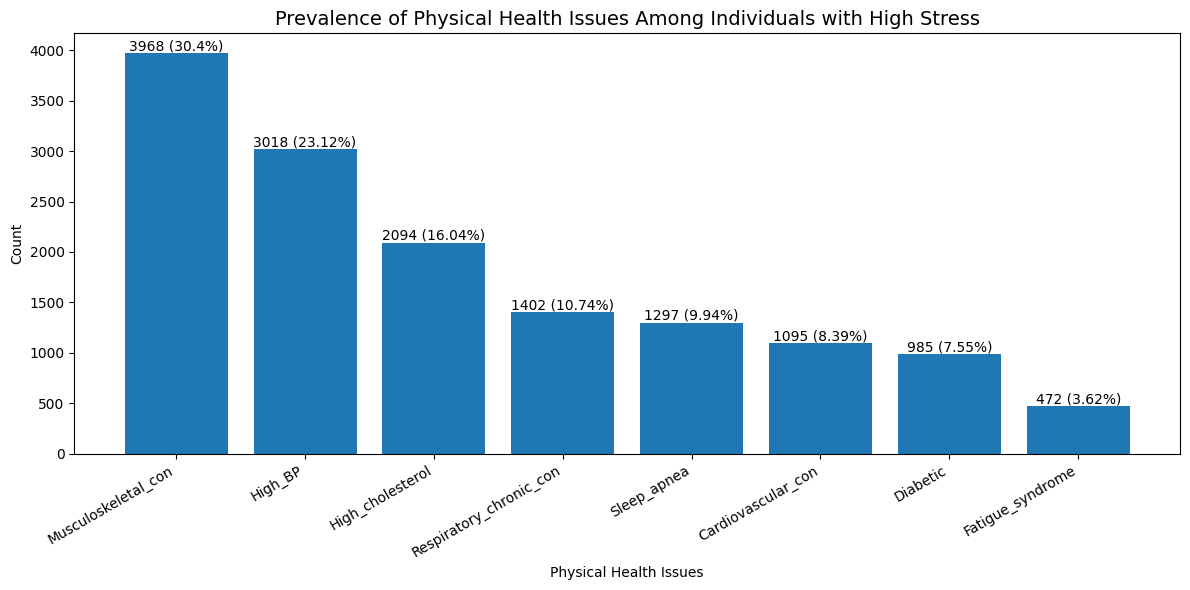

In [ ]:
# Variables of Physical Health Issues
variables = [
    'Sleep_apnea',
    'High_BP',
    'High_cholesterol',
    'Diabetic',
    'Fatigue_syndrome',
    'Respiratory_chronic_con',
    'Musculoskeletal_con',
    'Cardiovascular_con'
]

# Filter by cat_stress == 2
filtered_df = df[df['cat_stress'] == 2]

# Calculate count and percentage of 1s
results = []
total = filtered_df.shape[0]

for var in variables:
    count_1 = (filtered_df[var] == 1).sum()
    percentage_1 = (count_1 / total) * 100 if total > 0 else 0
    results.append({'Variable': var, 'Count_1': count_1, 'Percentage_1': round(percentage_1, 2)})

# Create DataFrame and sort
results_df = pd.DataFrame(results).sort_values(by='Count_1', ascending=False)

# Plot bar chart
plt.figure(figsize=(12, 6))
bars = plt.bar(results_df['Variable'], results_df['Count_1'])

# Add labels on top of bars (count and percentage)
for bar, pct in zip(bars, results_df['Percentage_1']):
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 1,  # position above bar
        f'{int(height)} ({pct}%)',
        ha='center',
        va='bottom',
        fontsize=10
    )

plt.title('Prevalence of Physical Health Issues Among Individuals with High Stress', fontsize=14)
plt.xlabel('Physical Health Issues')
plt.ylabel('Count')
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()


In [ ]:
# Cross-tab: raw counts
cross_tab = pd.crosstab(df['physical_health_issues_count'], df['cat_stress'])

# Display
print(cross_tab)

df['health_issue_group'] = pd.cut(
    df['physical_health_issues_count'],
    bins=[-1, 0, 2, float('inf')],  # Note: -1 to include 0 properly
    labels=['0', '1–2', '3+']
)

# Cross-tab: raw counts
cross_tab = pd.crosstab(df['health_issue_group'], df['cat_stress'])

# Display
print(cross_tab)


cat_stress                       1     2
physical_health_issues_count            
0                             9828  2271
1                             6344  1118
2                             4355   695
3                             2635   386
4                             1168   226
5                              378    89
6                              108    28
7                               17     9
8                                2     1
cat_stress              1     2
health_issue_group             
0                    9828  2271
1–2                 10699  1813
3+                   4308   739


In [ ]:
# Mann-Whitney U Test

def mann_whitney_test(df, group_col, target_col):
    # Split the data into two groups based on the categorical variable
    group1 = df[df[group_col] == 1][target_col]
    group2 = df[df[group_col] == 2][target_col]

    # Perform the Mann-Whitney U test
    p = stats.mannwhitneyu(group1, group2, alternative='two-sided')

    # Print the results
    print(f"Mann-Whitney U p-value: {p}")

mann_whitney_test(df, 'health_issue_group', 'cat_stress')


Mann-Whitney U p-value: MannwhitneyuResult(statistic=np.float64(nan), pvalue=np.float64(nan))


<ipython-input-21-af91776dcfd6>:9: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  p = stats.mannwhitneyu(group1, group2, alternative='two-sided')


## Mann_Witney U test - Focused on Working Status (Gemini Generated)

<ipython-input-24-16a7fd4925ed>:18: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  u_statistic, p_value = stats.mannwhitneyu(stress_working, stress_not_working, alternative='greater')



--- Mann-Whitney U Test: Stress Level by Working Status ---
Mann-Whitney U statistic: nan
P-value: nan
Result: Fail to reject the null hypothesis.
There is not enough evidence to conclude that the Stress_level is higher in individuals who are working compared to those who are not working.
------------------------------------------------------


<ipython-input-24-16a7fd4925ed>:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Working_Label', y='Stress_level', data=df, palette='Set2')


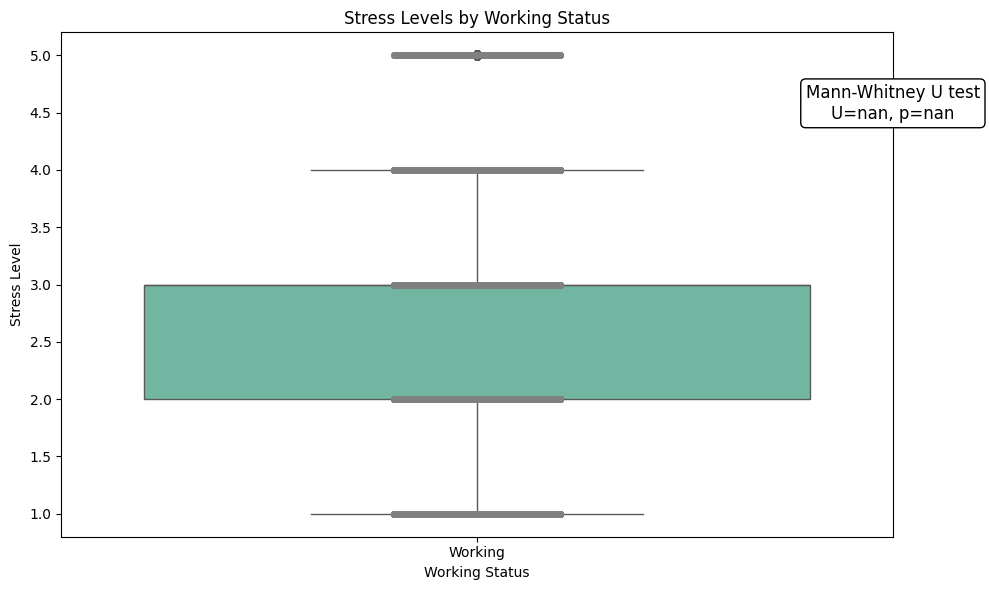

In [ ]:
# prompt: can u do mann-winey u test to test whether working status = working has higher stress than not working ?
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import mannwhitneyu

# Perform Mann-Whitney U test to compare stress levels between working statuses
# H0: The distribution of Stress_level is the same for working (working_status=1) and not working (working_status=2).
# H1: The distribution of Stress_level is higher for working (working_status=1) than for not working (working_status=2).

# Extract the Stress_level for working (working_status=1) and not working (working_status=2)
stress_working = df[df['working_status'] == 1]['Stress_level']
stress_not_working = df[df['working_status'] == 2]['Stress_level']

# Perform Mann-Whitney U test
# 'greater' alternative tests if the first sample (working) has ranks/values
# that are *greater* than the second sample (not working).
u_statistic, p_value = stats.mannwhitneyu(stress_working, stress_not_working, alternative='greater')

# Print the results
print("\n--- Mann-Whitney U Test: Stress Level by Working Status ---")
print(f"Mann-Whitney U statistic: {u_statistic}")
print(f"P-value: {p_value}")

# Interpret the result
alpha = 0.05
if p_value < alpha:
    print("Result: Reject the null hypothesis.")
    print("There is significant evidence that the Stress_level is higher in individuals who are working compared to those who are not working.")
else:
    print("Result: Fail to reject the null hypothesis.")
    print("There is not enough evidence to conclude that the Stress_level is higher in individuals who are working compared to those who are not working.")

print("------------------------------------------------------")


# Create a label for annotation
result_text = f'Mann-Whitney U test\nU={u_statistic:.2f}, p={p_value:.4f}'

# Map working_status to readable labels
df['Working_Label'] = df['working_status'].map({1: 'Working', 2: 'Not Working'})

# Plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Working_Label', y='Stress_level', data=df, palette='Set2')
sns.stripplot(x='Working_Label', y='Stress_level', data=df, color='gray', alpha=0.5, jitter=True)

# Annotate the result
plt.title('Stress Levels by Working Status')
plt.xlabel('Working Status')
plt.ylabel('Stress Level')
plt.text(0.5, df['Stress_level'].max() * 0.95, result_text, ha='center', va='top', fontsize=12, bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"))

plt.tight_layout()
plt.show()


### We filtered out those data have working status = working

In [ ]:
df_working = df[df['working_status'] == 1].copy()

print(df_working.head())
df_working.shape

    Gender  Marital_status  Age  Edu_level  Stress_level  working_status  \
0        2               1    3          3             2               1   
10       2               1    2          3             3               1   
12       2               2    4          3             2               1   
20       1               1    4          3             4               1   
21       2               2    2          3             3               1   

    Smoked  weekly_alcohol  Cannabis_use  Drug_use  ...  Sleep_apnea  High_BP  \
0        2               2             2         2  ...            2        2   
10       2               1             2         6  ...            2        2   
12       2               1             2         6  ...            2        1   
20       2               2             2         2  ...            2        2   
21       2               2             2         2  ...            2        2   

    High_cholesterol  Diabetic  Fatigue_syndrome  Respir

(30898, 21)

In [ ]:
# Perform Spearman correlation test for each group
grouped_data = df_working.groupby(['Gender', 'Marital_status', 'any_substance_use'])

correlation_results = {}

for name, group in grouped_data:
    # Check if the group has enough data points and variance for correlation
    if group.shape[0] >= 2 and group['Stress_level'].nunique() > 1 and group['physical_health_issues_count'].nunique() > 1:
        # Conduct Spearman correlation test
        correlation, p_value = stats.spearmanr(group['Stress_level'], group['physical_health_issues_count'])
        correlation_results[name] = {'Spearman Correlation': correlation, 'P-value': p_value, 'Count': group.shape[0]}
    else:
        correlation_results[name] = {'Spearman Correlation': None, 'P-value': None, 'Count': group.shape[0]}
        print(f"Skipping group {name} due to insufficient data ({group.shape[0]} rows) or lack of variance.")


# Print the results
print("\n--- Spearman Correlation between Stress Level and Number of Physical Health Issues ---")
print("Grouped by Gender, Marital Status, and Any Substance Use (Working Individuals Only)")

# Convert results to a DataFrame for better display
results_df = pd.DataFrame.from_dict(correlation_results, orient='index')
results_df.index.names = ['Gender', 'Marital_status', 'Any_Substance_Use']

# Map numerical values to descriptive labels for better interpretation
gender_map = {1: 'Male', 2: 'Female'}
marital_map = {1: 'Married', 2: 'Single'}
substance_map = {0: 'No', 1: 'Yes'}

results_df.index = results_df.index.map(
    lambda x: (gender_map.get(x[0], f'Unknown({x[0]})'),
               marital_map.get(x[1], f'Unknown({x[1]})'),
               substance_map.get(x[2], f'Unknown({x[2]})'))
)

print(results_df)
print("-------------------------------------------------------------------------------------")

# Interpretation helper
alpha = 0.05

print("\nInterpretation (Significance level = 0.05):")
for group, row in results_df.iterrows():
    corr = row['Spearman Correlation']
    p = row['P-value']
    count = row['Count']

    gender, marital, substance = group

    if corr is None:
         print(f"- For Group (Gender: {gender}, Marital: {marital}, Substance Use: {substance}, Count: {count}): Correlation could not be calculated.")
    else:
        sig_status = "Statistically Significant (p < 0.05)" if p < alpha else "Not Statistically Significant (p >= 0.05)"
        direction = "positive" if corr > 0 else ("negative" if corr < 0 else "negligible")
        strength = "weak" if abs(corr) < 0.3 else ("moderate" if abs(corr) < 0.7 else "strong")

        print(f"- For Group (Gender: {gender}, Marital: {marital}, Substance Use: {substance}, Count: {count}):")
        print(f"  Spearman's Rho: {corr:.3f}, P-value: {p:.3f}")
        print(f"  Result: {sig_status}. There is a {strength} {direction} correlation.")

print("-------------------------------------------------------------------------------------")


--- Spearman Correlation between Stress Level and Number of Physical Health Issues ---
Grouped by Gender, Marital Status, and Any Substance Use (Working Individuals Only)
                                         Spearman Correlation       P-value  \
Gender Marital_status Any_Substance_Use                                       
Male   Married        No                             0.110891  3.583032e-10   
                      Yes                            0.081069  3.369186e-10   
       Single         No                             0.140471  9.536562e-09   
                      Yes                            0.083562  6.663940e-08   
Female Married        No                             0.094004  3.623246e-09   
                      Yes                            0.051029  1.110630e-04   
       Single         No                             0.090316  2.515596e-05   
                      Yes                            0.065792  2.567275e-05   

                                     

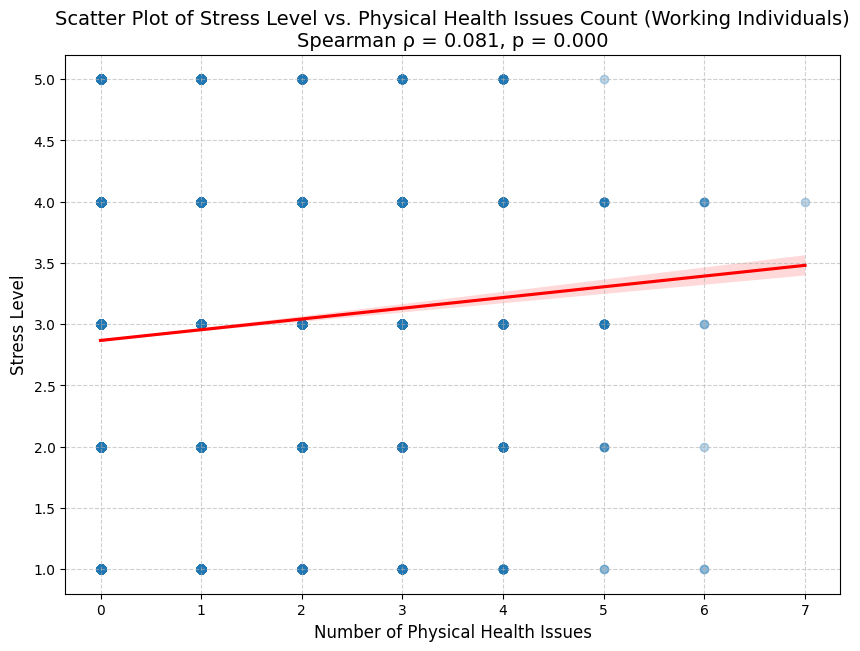

In [ ]:
# Define the columns for the scatter plot
x_col = 'physical_health_issues_count'
y_col = 'Stress_level'

# Calculate Spearman correlation for the overall working population
spearman_corr, spearman_p = stats.spearmanr(df_working[x_col], df_working[y_col])

plt.figure(figsize=(10, 7))

# Create the scatter plot using Seaborn's regplot
# regplot automatically calculates and plots the best-fit line and scatter points
sns.regplot(x=x_col, y=y_col, data=df_working, scatter_kws={'alpha':0.3}, line_kws={"color": "red"})

# Add title with the Spearman correlation coefficient and p-value
plt.title(f'Scatter Plot of Stress Level vs. Physical Health Issues Count (Working Individuals)\n'
          f'Spearman ρ = {spearman_corr:.3f}, p = {spearman_p:.3f}', fontsize=14)
plt.xlabel('Number of Physical Health Issues', fontsize=12)
plt.ylabel('Stress Level', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

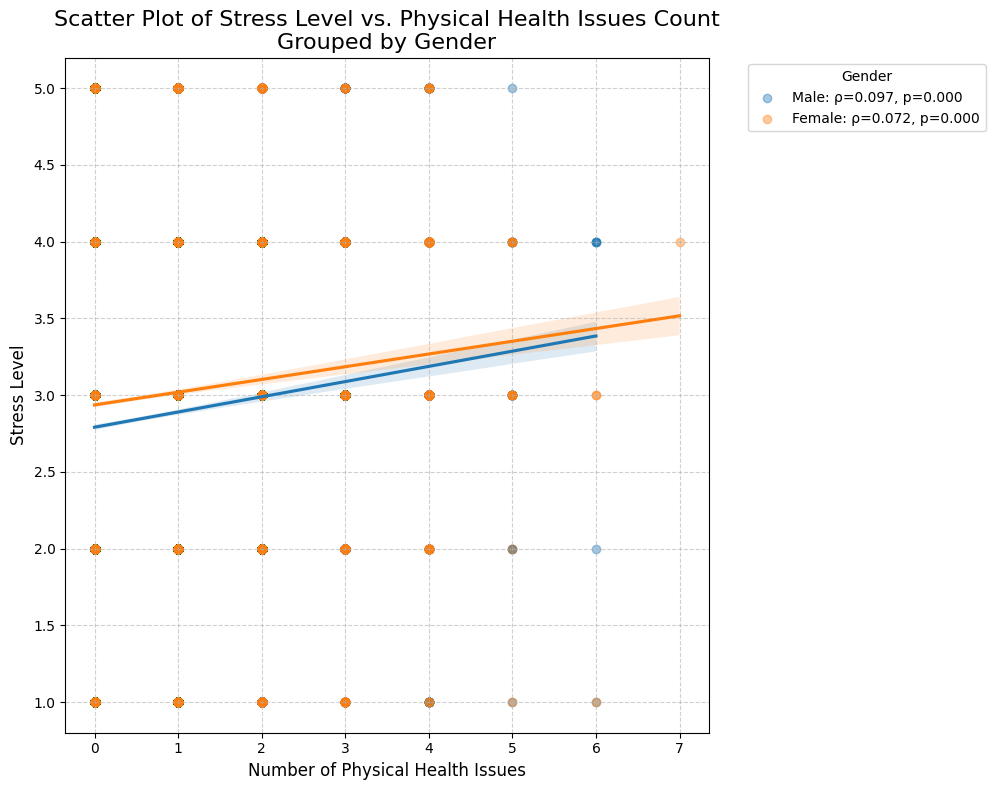

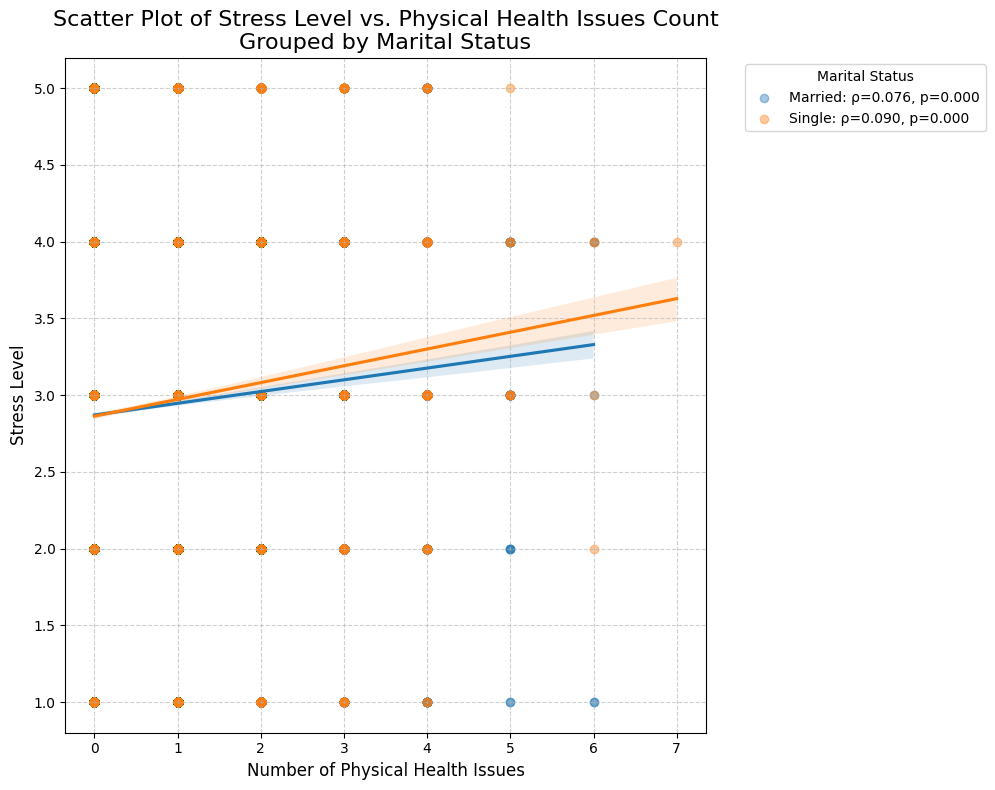

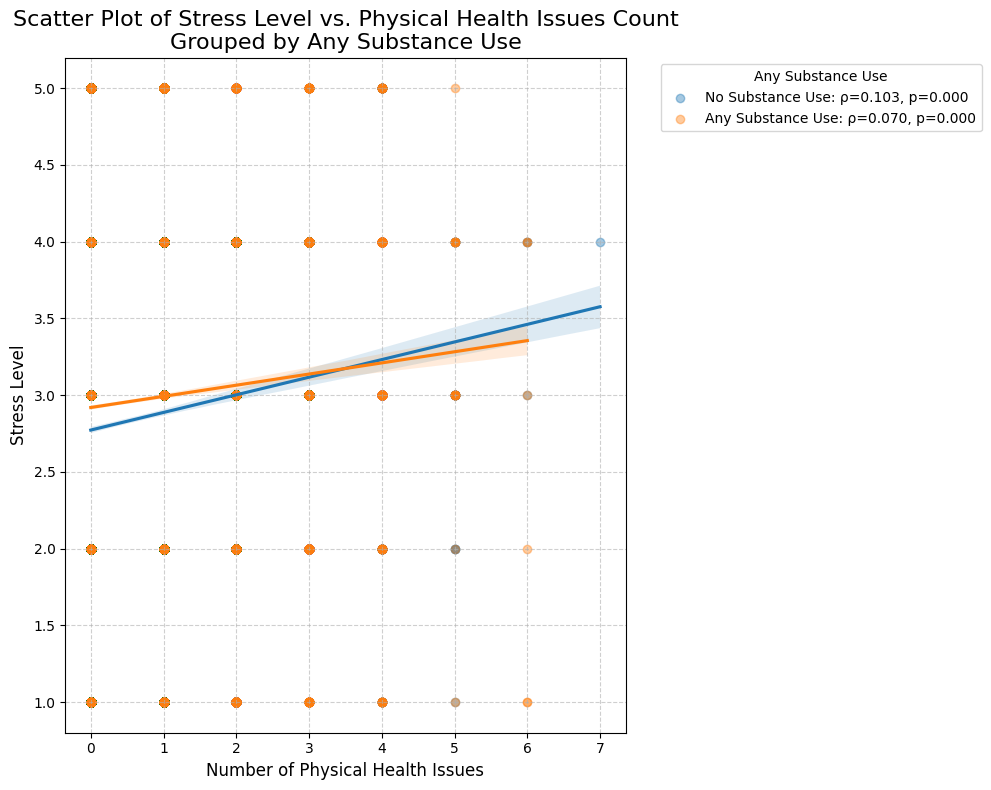

In [ ]:
def plot_grouped_scatter(df, group_col, group_labels, x_col, y_col, title_prefix):
    plt.figure(figsize=(12, 8))

    for group_value, label in group_labels.items():
        group_df = df[df[group_col] == group_value]

        if not group_df.empty:
            # Calculate Spearman correlation for the subgroup
            if group_df[x_col].nunique() > 1 and group_df[y_col].nunique() > 1:
                spearman_corr, spearman_p = stats.spearmanr(group_df[x_col], group_df[y_col])
                line_label = f'{label}: ρ={spearman_corr:.3f}, p={spearman_p:.3f}'
            else:
                line_label = f'{label}: Insufficient data for correlation'
                spearman_corr = None # Indicate no valid correlation
                spearman_p = None

            # Use regplot for scatter and best-fit line
            sns.regplot(x=x_col, y=y_col, data=group_df, scatter_kws={'alpha': 0.4}, label=line_label)

    plt.title(f'Scatter Plot of Stress Level vs. Physical Health Issues Count\nGrouped by {title_prefix}', fontsize=16)
    plt.xlabel('Number of Physical Health Issues', fontsize=12)
    plt.ylabel('Stress Level', fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.legend(title=title_prefix, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust layout to make space for the legend
    plt.show()

# Scatter plot grouped by Gender
gender_labels = {1: 'Male', 2: 'Female'}
plot_grouped_scatter(df_working, 'Gender', gender_labels, x_col, y_col, 'Gender')

# Scatter plot grouped by Marital_status
marital_labels = {1: 'Married', 2: 'Single'}
plot_grouped_scatter(df_working, 'Marital_status', marital_labels, x_col, y_col, 'Marital Status')

# Scatter plot grouped by any_substance_use
substance_labels = {0: 'No Substance Use', 1: 'Any Substance Use'}
plot_grouped_scatter(df_working, 'any_substance_use', substance_labels, x_col, y_col, 'Any Substance Use')

# Other Test

In [ ]:
# prompt: can u do mann-winey u test to test whether age 4,5 have a higher stress level than age 2,3

# Define the age groups
age_group_2_3 = df[df['Age'].isin([2, 3])]['Stress_level']
age_group_4_5 = df[df['Age'].isin([4, 5])]['Stress_level']

# Perform Mann-Whitney U test
u_statistic, p_value = stats.mannwhitneyu(age_group_2_3, age_group_4_5, alternative='less')

# Print the results
print(f"Mann-Whitney U statistic: {u_statistic}")
print(f"P-value: {p_value}")

# Interpret the result
alpha = 0.05
if p_value < alpha:
    print("Result: Reject the null hypothesis. Stress level is significantly lower in age group 2-3 compared to age group 4-5.")
else:
    print("Result: Fail to reject the null hypothesis. There is no significant evidence that stress level is lower in age group 2-3 compared to age group 4-5.")

# Note: We used 'less' as the alternative hypothesis because the user asked
# if age 4,5 have *higher* stress, which means age 2,3 would have *lower* stress.
# If you wanted to test if they are simply *different* (not necessarily lower/higher),
# you would use alternative='two-sided'.

Mann-Whitney U statistic: 872933899.5
P-value: 1.0
Result: Fail to reject the null hypothesis. There is no significant evidence that stress level is lower in age group 2-3 compared to age group 4-5.


In [ ]:
# prompt: can u do mann-winey u test to test whether age 4,5 have a high number of high stress than age 2,3

# Filter the DataFrame to include only the relevant age groups and stress categories
# We are interested in the count of 'High stress' (cat_stress == 2)
high_stress_age_group_2_3 = df[(df['Age'].isin([2, 3])) & (df['cat_stress'] == 2)]
high_stress_age_group_4_5 = df[(df['Age'].isin([4, 5])) & (df['cat_stress'] == 2)]

# We want to test if the distribution of a measure related to "high stress"
# is higher in the 4-5 age group than in the 2-3 age group.
# Since the Mann-Whitney U test compares the ranks of independent samples
# on an ordinal or continuous variable, we can't directly apply it to just
# counts of 'high stress'.
# A more appropriate approach here is to compare the *Stress_level* (1-5 scale)
# between the two age groups using the Mann-Whitney U test, with an alternative
# hypothesis that the stress levels are higher in the older group.

# Extract the Stress_level for the two groups
stress_level_age_2_3 = df[df['Age'].isin([2, 3])]['Stress_level']
stress_level_age_4_5 = df[df['Age'].isin([4, 5])]['Stress_level']

# Perform Mann-Whitney U test
# H0: The distribution of Stress_level is the same for age groups 2-3 and 4-5.
# H1: The distribution of Stress_level is higher for age group 4-5 than for age group 2-3.
u_statistic, p_value = stats.mannwhitneyu(stress_level_age_2_3, stress_level_age_4_5, alternative='less') # 'less' because we are testing if 2-3 is 'less' than 4-5 (meaning 4-5 is 'greater')

# Print the results
print(f"Mann-Whitney U statistic: {u_statistic}")
print(f"P-value: {p_value}")

# Interpret the result
alpha = 0.05
if p_value < alpha:
    print("Result: Reject the null hypothesis.")
    print("There is significant evidence that the Stress_level is higher in age group 4-5 compared to age group 2-3.")
else:
    print("Result: Fail to reject the null hypothesis.")
    print("There is not enough evidence to conclude that the Stress_level is higher in age group 4-5 compared to age group 2-3.")

# Note: This test compares the distribution of Stress_level (on the 1-5 scale)
# between the two age groups. A lower p-value for the 'less' alternative hypothesis
# suggests that the ranks (and thus the values) in the first sample (age 2-3)
# tend to be lower than in the second sample (age 4-5). This aligns with testing
# if the older group (4-5) has higher stress levels.

Mann-Whitney U statistic: 872933899.5
P-value: 1.0
Result: Fail to reject the null hypothesis.
There is not enough evidence to conclude that the Stress_level is higher in age group 4-5 compared to age group 2-3.


In [ ]:
# prompt: can u do mann-winey u test to test whether female has higher stress than male?

# Perform Mann-Whitney U test to compare stress levels between genders
# H0: The distribution of Stress_level is the same for males (Gender=1) and females (Gender=2).
# H1: The distribution of Stress_level is higher for females (Gender=2) than for males (Gender=1).

# Extract the Stress_level for males (Gender=1) and females (Gender=2)
stress_male = df[df['Gender'] == 1]['Stress_level']
stress_female = df[df['Gender'] == 2]['Stress_level']

# Perform Mann-Whitney U test
# 'greater' alternative tests if the first sample (males) has ranks/values
# that are *greater* than the second sample (females).
# To test if females have *higher* stress (meaning their values/ranks are greater),
# we compare female stress levels to male stress levels.
u_statistic, p_value = stats.mannwhitneyu(stress_female, stress_male, alternative='greater')

# Print the results
print("\n--- Mann-Whitney U Test: Stress Level by Gender ---")
print(f"Mann-Whitney U statistic: {u_statistic}")
print(f"P-value: {p_value}")

# Interpret the result
alpha = 0.05
if p_value < alpha:
    print("Result: Reject the null hypothesis.")
    print("There is significant evidence that the Stress_level is higher in females compared to males.")
else:
    print("Result: Fail to reject the null hypothesis.")
    print("There is not enough evidence to conclude that the Stress_level is higher in females compared to males.")

print("-------------------------------------------------")


--- Mann-Whitney U Test: Stress Level by Gender ---
Mann-Whitney U statistic: 825575977.0
P-value: 6.317359672235151e-56
Result: Reject the null hypothesis.
There is significant evidence that the Stress_level is higher in females compared to males.
-------------------------------------------------


In [ ]:
# Perform Spearman rank correlation
spearman_corr, spearman_pvalue = stats.spearmanr(group1_physical_issues['physical_health_issues_count'], group1_physical_issues['Stress_level'])

print("\nSpearman Rank Correlation Test:")
print(f"  Correlation Coefficient = {spearman_corr:.4f}")
print(f"  P-value   = {spearman_pvalue:.4f}")

# Interpretation
alpha = 0.05
if spearman_pvalue < alpha:
    print(f"  Interpretation: There is a statistically significant monotonic relationship between the number of physical health issues and stress level (p < {alpha}).")
    if spearman_corr > 0:
        print("  This indicates a positive monotonic relationship (as physical health issues increase, stress level tends to increase).")
    elif spearman_corr < 0:
        print("  This indicates a negative monotonic relationship (as physical health issues increase, stress level tends to decrease).")
    else:
         print("  The monotonic relationship is close to zero.")
else:
    print(f"  Interpretation: There is no statistically significant monotonic relationship between the number of physical health issues and stress level (p >= {alpha}).")


Spearman Rank Correlation Test:
  Correlation Coefficient = 0.0444
  P-value   = 0.0000
  Interpretation: There is a statistically significant monotonic relationship between the number of physical health issues and stress level (p < 0.05).
  This indicates a positive monotonic relationship (as physical health issues increase, stress level tends to increase).


In [ ]:
group1_physical_issues = df[df['Age'].isin([4,5])]
# group2_physical_issues = df[(df['cat_stress'] == 2) & (df['Age'].isin([4,5]))]

In [ ]:
age_df = df[df['Age'] >= 4]
spearman_corr, spearman_pvalue = stats.spearmanr(age_df['physical_health_issues_count'], age_df['Stress_level'])

print("\nSpearman Rank Correlation Test:")
print(f"  Correlation Coefficient = {spearman_corr:.4f}")
print(f"  P-value   = {spearman_pvalue:.4f}")


Spearman Rank Correlation Test:
  Correlation Coefficient = 0.0444
  P-value   = 0.0000


# Hiding previous code

**Suggestion for independent variable and dependent variable **

Independent Variables (Stress-related — potential causes)
*   Stress_level — Perceived daily stress (primary independent variable)
*   Work_stress — Stress experienced at work
*   Mental_health_state — Self-rated mental health status
*   Life_satisfaction — Overall satisfaction with life (inverse indicator of stress)
*   Food_security — Low food security can be a stressor
*   Sense_belonging — Low sense of belonging may increase stress
*   Work_hours — Long working hours may contribute to stress
*   Working_status — Unemployment or job insecurity as stress sources

Dependent Variables (Physical health—related — outcomes)
*   Gen_health_state — General self-assessed health
*   Health_utility_index — Quantified health status
*   Pain_status — Frequency/severity of pain
*   Weight_state — BMI-based weight category
*   BMI_12_17 / BMI_18_above — Body mass index (age-specific)
*   Sleep_apnea — Diagnosed sleep apnea
*   Fatigue_syndrome — Diagnosed chronic fatigue syndrome
*   High_BP — Diagnosed high blood pressure
*   High_cholesterol — Diagnosed high cholesterol
*   Diabetic — Diagnosed with diabetes
*   Cardiovascular_con — Diagnosed cardiovascular condition
*   Respiratory_chronic_con — Diagnosed chronic respiratory condition
*   Musculoskeletal_con — Diagnosed musculoskeletal condition
*   Act_improve_health — Engagement in health-improving behaviors
*   Total_active_time / Physical_vigorous_act_time — Time spent on physical activity
*   Smoked / Tobacco_use — Smoking behavior
*   Weekly_alcohol — Frequency of alcohol consumption
*   Drug_use — Use of illicit drugs

In [ ]:
# Data Cleaning
# - grouping "valid skip", "Refused", "Don't know" and "Not stated" into same code and remove them

df.loc[:, 'Marital_status'] = df['Marital_status'].replace({6:9})
df = df[df.Marital_status != 9]
print("Marital_status:", df.Marital_status.unique())

# df = df[df.Household != 9]
print("Household: ", df.Household.unique())

df.loc[:, 'Worked_job_business'] = df['Worked_job_business'].replace({6:9, 7:9, 8:9})
# df = df[df.Worked_job_business != 9]
print("Worked_job_business: ", df.Worked_job_business.unique())

df = df[df.Edu_level != 9]
print("Edu_level: ", df.Edu_level.unique())

df.loc[:, 'Gen_health_state'] = df['Gen_health_state'].replace({7:9, 8:9})
# df = df[df.Gen_health_state != 9]
print("Gen_health_state: ", df.Gen_health_state.unique())

df.loc[:, 'Life_satisfaction'] = df['Life_satisfaction'].replace({97:99, 98:99})
# df = df[df.Life_satisfaction != 99]
print("Life_satisfaction: ", df.Life_satisfaction.unique())

df.loc[:, 'Mental_health_state'] = df['Mental_health_state'].replace({7:9, 8:9})
# df = df[df.Mental_health_state != 9]
print("Mental_health_state: ", df.Mental_health_state.unique())

df.loc[:, 'Stress_level'] = df['Stress_level'].replace({7:9, 8:9})
df = df[df.Stress_level != 9]
print("Stress_level: ", df.Stress_level.unique())

df.loc[:, 'Work_stress'] = df['Work_stress'].replace({6:9, 7:9, 8:9})
# df = df[df.Work_stress != 9]
print("Work_stress: ", df.Work_stress.unique())

df.loc[:, 'Sense_belonging'] = df['Sense_belonging'].replace({7:9, 8:9})
# df = df[df.Sense_belonging != 9]
print("Sense_belonging: ", df.Sense_belonging.unique())

df.loc[:, 'Weight_state'] = df['Weight_state'].replace({6:9, 7:9, 8:9})
# df = df[df.Weight_state != 9]
print("Weight_state: ", df.Weight_state.unique())

df.loc[:, 'BMI_12_17'] = df['BMI_12_17'].replace({6:9})
# df = df[df.BMI_12_17 != 9]
print("BMI_12_17: ", df.BMI_12_17.unique())

df.loc[:, 'BMI_18_above'] = df['BMI_18_above'].replace({6:9})
# df = df[df.BMI_18_above != 9]
print("BMI_18_above: ", df.BMI_18_above.unique())

df.loc[:, 'Sleep_apnea'] = df['Sleep_apnea'].replace({7:9, 8:9})
df = df[df.Sleep_apnea != 9]
print("Sleep_apnea: ", df.Sleep_apnea.unique())

df.loc[:, 'High_BP'] = df['High_BP'].replace({7:9, 8:9})
df = df[df.High_BP != 9]
print("High_BP: ", df.High_BP.unique())

df.loc[:, 'High_cholestrol'] = df['High_cholestrol'].replace({6:9, 7:9, 8:9})
df = df[df.High_cholestrol != 9]
print("High_cholestrol: ", df.High_cholestrol.unique())

# valid skip for Prediabetes and should count as no
df.loc[:, 'Diabetic'] = df['Diabetic'].replace({7:6, 8:9})
df = df[df.Diabetic != 9]
print("Diabetic: ", df.Diabetic.unique())

df.loc[:, 'Fatigue_syndrome'] = df['Fatigue_syndrome'].replace({7:9, 8:9})
df = df[df.Fatigue_syndrome != 9]
print("Fatigue_syndrome: ", df.Fatigue_syndrome.unique())

df.loc[:, 'Mood_disorder'] = df['Mood_disorder'].replace({7:9, 8:9})
# df = df[df.Mood_disorder != 9]
print("Mood_disorder: ", df.Mood_disorder.unique())

df.loc[:, 'Anxiety_disorder'] = df['Anxiety_disorder'].replace({7:9, 8:9})
# df = df[df.Anxiety_disorder != 9]
print("Anxiety_disorder: ", df.Anxiety_disorder.unique())

df = df[df.Respiratory_chronic_con != 9]
print("Respiratory_chronic_con: ", df.Respiratory_chronic_con.unique())

df.loc[:, 'Musculoskeletal_con'] = df['Musculoskeletal_con'].replace({6:9})
df = df[df.Musculoskeletal_con != 9]
print("Musculoskeletal_con: ", df.Musculoskeletal_con.unique())

df = df[df.Cardiovascular_con != 9]
print("Cardiovascular_con: ", df.Cardiovascular_con.unique())

# df = df[df.Health_utility_indx != 9]
print("Health_utility_indx: ", df.Health_utility_indx.unique())

# df = df[df.Pain_status != 9]
print("Pain_status: ", df.Pain_status.unique())

df.loc[:, 'Act_improve_health'] = df['Act_improve_health'].replace({6:9, 7:9, 8:9})
# df = df[df.Act_improve_health != 9]
print("Act_improve_health: ", df.Act_improve_health.unique())

# df.loc[:, 'Fruit_veg_con'] = df['Fruit_veg_con'].replace({6:9, 7:9, 8:9})
# # df = df[df.Fruit_veg_con != 9]
# print("Fruit_veg_con: ", df.Fruit_veg_con.unique())

df.loc[:, 'Smoked'] = df['Smoked'].replace({996:2})
df = df[df.Smoked != 999]
print("Smoked: ", df.Smoked.unique())

df.loc[:, 'Tobaco_use'] = df['Tobaco_use'].replace({6:9})
# df = df[df.Tobaco_use != 9]
print("Tobaco_use: ", df.Tobaco_use.unique())

df.loc[:, 'weekly_alcohol'] = df['weekly_alcohol'].replace({996:2})
df = df[df.weekly_alcohol != 999]
print("weekly_alcohol: ", df.weekly_alcohol.unique())

df.loc[:, 'Cannabies_use'] = df['Cannabies_use'].replace({7:9, 8:9})
# df = df[df.Cannabies_use != 9]
print("Cannabies_use: ", df.Cannabies_use.unique())

df.loc[:, 'Drug_use'] = df['Drug_use'].replace({6:9})
# df = df[df.Drug_use != 9]
print("Drug_use: ", df.Drug_use.unique())

# df.loc[:, 'Total_active_time'] = df['Total_active_time'].replace({6:9})
# # df = df[df.Total_active_time != 9]
# print("Total_active_time: ", df.Total_active_time.unique())

# df.loc[:, 'Total_physical_act_time'] = df['Total_physical_act_time'].replace({6:9})
# # df = df[df.Total_physical_act_time != 9]
# print("Total_physical_act_time: ", df.Total_physical_act_time.unique())

# df.loc[:, 'Other_physical_act_time'] = df['Other_physical_act_time'].replace({6:9})
# # df = df[df.Other_physical_act_time != 9]
# print("Other_physical_act_time: ", df.Other_physical_act_time.unique())

# df.loc[:, 'Physical_vigorous_act_time'] = df['Physical_vigorous_act_time'].replace({6:9})
# # df = df[df.Physical_vigorous_act_time != 9]
# print("Physical_vigorous_act_time: ", df.Physical_vigorous_act_time.unique())

df.loc[:, 'Work_hours'] = df['Work_hours'].replace({96:99})
# df = df[df.Work_hours != 99]
print("Work_hours: ", df.Work_hours.unique())

df.loc[:, 'working_status'] = df['working_status'].replace({6:3})
df = df[df.working_status != 9]
print("working_status: ", df.working_status.unique())

df.loc[:, 'Aboriginal_identity'] = df['Aboriginal_identity'].replace({7:9, 8:9})
# df = df[df.Aboriginal_identity != 9]
print("Aboriginal_identity: ", df.Aboriginal_identity.unique())

# df = df[df.Birth_country != 9]
print("Birth_country: ", df.Birth_country.unique())

df.loc[:, 'Insurance_cover'] = df['Insurance_cover'].replace({6:9, 7:9, 8:9})
# df = df[df.Insurance_cover != 9]
print("Insurance_cover: ", df.Insurance_cover.unique())

df.loc[:, 'Food_security'] = df['Food_security'].replace({6:9})
# df = df[df.Food_security != 9]
print("Food_security: ", df.Food_security.unique())

# df = df[df.Income_source != 9]
print("Income_source: ", df.Income_source.unique())

# df = df[df.Total_income != 9]
print("Total_income: ", df.Total_income.unique())

df.shape

Marital_status: [1 2]
Household:  [2 1 9]
Worked_job_business:  [1 9 2]
Edu_level:  [3 2 1]
Gen_health_state:  [3 2 5 1 4 9]
Life_satisfaction:  [ 9  4  7  8  0 10  6  5 99  3  2  1]
Mental_health_state:  [3 5 2 1 4 9]
Stress_level:  [2 3 4 1 5]
Work_stress:  [2 9 4 3 1 5]
Sense_belonging:  [2 3 1 4 9]
Weight_state:  [3 1 9 2]
BMI_12_17:  [9]
BMI_18_above:  [2 1 9]
Sleep_apnea:  [2 1]
High_BP:  [2 1]
High_cholestrol:  [2 1]
Diabetic:  [2 1 6]
Fatigue_syndrome:  [2 1]
Mood_disorder:  [2 1 9]
Anxiety_disorder:  [2 1 9]
Respiratory_chronic_con:  [2 1]
Musculoskeletal_con:  [2 1]
Cardiovascular_con:  [2 1]
Health_utility_indx:  [1 9 2]
Pain_status:  [2 1 9]
Act_improve_health:  [9 2 1]
Smoked:  [ 2.  7. 10. 55. 15. 25. 20.  3.  1.  5. 12.  6. 17.  4. 50. 18. 40.  8.
 14. 30.  9. 16. nan 13. 44. 11. 80. 37. 36. 35. 23. 60. 22. 24. 27. 19.
 33. 75. 21. 39. 32. 38. 26. 54. 28. 58.]
Tobaco_use:  [9 2 1]
weekly_alcohol:  [  2   4   3  11   0   1  10  12   5  35   7   8  14  22  36  18   6  17
 

(79416, 50)

In [ ]:
for i in df.columns:
    print(f"Column: {i}")
    print(df[i].value_counts(dropna=False))
    print("-" * 50)

Column: ADM_RNO1
ADM_RNO1
999998    1
1000      1
100005    1
100012    1
100015    1
         ..
100104    1
100093    1
10009     1
100086    1
100080    1
Name: count, Length: 79416, dtype: int64
--------------------------------------------------
Column: Province
Province
35    21425
24    14175
48     9322
59     8393
46     4828
47     4467
12     4303
10     4224
13     3915
11     3506
60      858
Name: count, dtype: int64
--------------------------------------------------
Column: Health_region_ grouped
Health_region_ grouped
11900    3506
48932    2833
46901    2726
35995    2695
48934    2675
         ... 
35927     295
35934     292
35955     280
59912     262
47909     231
Name: count, Length: 91, dtype: int64
--------------------------------------------------
Column: Gender
Gender
2    44143
1    35273
Name: count, dtype: int64
--------------------------------------------------
Column: Marital_status
Marital_status
1    45420
2    33996
Name: count, dtype: int64
-----------

In [ ]:
# null_percentage_optional = (df.isnull().sum() / len(df)) * 100

# print("Percentage of null values per column:")
# print(null_percentage_optional.sort_values(ascending=True))
# print()

df.isnull().sum()

df = df.dropna()

In [ ]:
df.describe()

,ADM_RNO1,Province,Health_region_ grouped,Gender,Marital_status,Household,Age,Worked_job_business,Edu_level,Gen_health_state,...,Physical_vigorous_act_time,Work_hours,working_status,Aboriginal_identity,Birth_country,Immigrant,Insurance_cover,Food_security,Income_source,Total_income
count,79357.000000,79357.000000,79357.000000,79357.000000,79357.000000,79357.000000,79357.000000,79357.000000,79357.000000,79357.000000,...,79357.000000,79357.000000,79357.000000,79357.000000,79357.000000,79357.000000,79357.000000,79357.000000,79357.000000,79357.000000
mean,501170.556876,33.992641,34917.526041,1.555893,1.428028,1.700594,4.033759,5.072483,2.665335,2.375405,...,7859.795821,75.370289,2.272352,2.117268,1.282067,1.927769,7.608125,1.187696,2.321786,3.880477
std,288761.233518,15.319489,15327.085015,0.496869,0.494796,0.623139,1.121711,3.934572,0.636325,1.031263,...,4090.150483,30.244005,0.935294,1.004669,1.003486,0.912125,2.984336,2.899303,2.431394,1.435990
min,21.000000,10.000000,10911.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000
25%,250937.000000,24.000000,24905.000000,1.000000,1.000000,1.000000,3.000000,1.000000,3.000000,2.000000,...,9996.000000,40.000000,1.000000,2.000000,1.000000,2.000000,9.000000,0.000000,1.000000,3.000000
50%,502082.000000,35.000000,35951.000000,2.000000,1.000000,2.000000,4.000000,2.000000,3.000000,2.000000,...,9996.000000,99.000000,3.000000,2.000000,1.000000,2.000000,9.000000,0.000000,2.000000,4.000000
75%,751175.000000,47.000000,47906.000000,2.000000,2.000000,2.000000,5.000000,9.000000,3.000000,3.000000,...,9996.000000,99.000000,3.000000,2.000000,1.000000,2.000000,9.000000,0.000000,2.000000,5.000000
max,999998.000000,60.000000,60901.000000,2.000000,2.000000,9.000000,5.000000,9.000000,3.000000,9.000000,...,9999.000000,99.000000,3.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000


Total_diagnosed_conditions
0    32805
1    19911
2    13217
3     7917
4     3789
5     1296
6      347
7       69
8        6
Name: count, dtype: int64
Stress_level
1    1.346492
2    1.251054
3    1.107039
4    1.059500
5    1.348851
Name: Total_diagnosed_conditions, dtype: float64


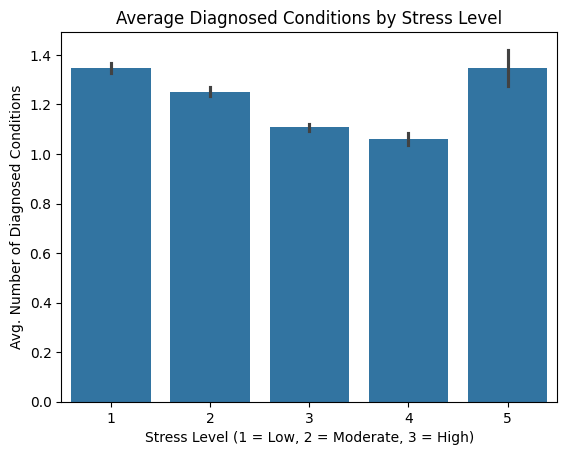

,Stress_level,Total_diagnosed_conditions
Stress_level,1.000000,-0.063425
Total_diagnosed_conditions,-0.063425,1.000000


In [ ]:
# List of diagnosis columns
diagnosis_cols = [
    "Sleep_apnea",
    "High_BP",
    "High_cholestrol",
    "Diabetic",
    "Fatigue_syndrome",
    "Respiratory_chronic_con",
    "Musculoskeletal_con",
    "Cardiovascular_con"
]

# Calculate total number of diagnosed conditions per respondent (value == 1)
df["Total_diagnosed_conditions"] = (df[diagnosis_cols] == 1).sum(axis=1)

print(df["Total_diagnosed_conditions"].value_counts())

print(df.groupby("Stress_level")["Total_diagnosed_conditions"].mean())

import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(
    x="Stress_level",
    y="Total_diagnosed_conditions",
    data=df,
    estimator="mean"
)
plt.title("Average Diagnosed Conditions by Stress Level")
plt.xlabel("Stress Level (1 = Low, 2 = Moderate, 3 = High)")
plt.ylabel("Avg. Number of Diagnosed Conditions")
plt.show()

df[["Stress_level", "Total_diagnosed_conditions"]].corr()

In [ ]:
# Regression with Interaction Terms
# To assess if the effect of Stress_level on Total_diagnosed_conditions significantly changes across demographic groups.

import statsmodels.formula.api as smf

# Assume df is your DataFrame, with categorical variables properly formatted
model = smf.ols("Total_diagnosed_conditions ~ Stress_level * Gender + Stress_level * Age + Stress_level * Total_income", data=df).fit()
print(model.summary())

                                OLS Regression Results                                
Dep. Variable:     Total_diagnosed_conditions   R-squared:                       0.287
Model:                                    OLS   Adj. R-squared:                  0.287
Method:                         Least Squares   F-statistic:                     4998.
Date:                        Tue, 29 Apr 2025   Prob (F-statistic):               0.00
Time:                                06:29:43   Log-Likelihood:            -1.3330e+05
No. Observations:                       86892   AIC:                         2.666e+05
Df Residuals:                           86884   BIC:                         2.667e+05
Df Model:                                   7                                         
Covariance Type:                    nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------

In [ ]:
#ANOVA
import scipy.stats as stats

for gender in df["Gender"].unique():
    subset = df[df["Gender"] == gender]
    groups = [subset[subset["Stress_level"] == level]["Total_diagnosed_conditions"] for level in [1, 2, 3]]
    f, p = stats.f_oneway(*groups)
    print(f"Gender: {gender} - ANOVA p-value: {p}")

Gender: 2 - ANOVA p-value: 4.989785854524156e-41
Gender: 1 - ANOVA p-value: 8.655400599998229e-46


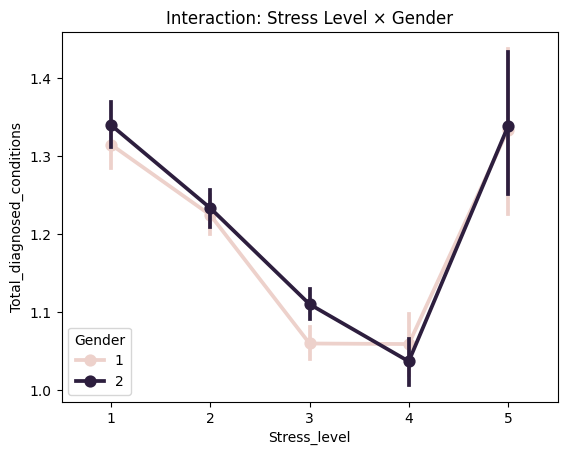

In [ ]:
#Interaction Plots

sns.pointplot(x="Stress_level", y="Total_diagnosed_conditions", hue="Gender", data=df)
plt.title("Interaction: Stress Level × Gender")
plt.show()

In [ ]:
# # Paired T-test
# print("Work stress mean:", df['Work_stress'].mean())
# print("Daily life stress mean:", df['Stress_level'].mean())

# work_stress = df['Work_stress']
# life_stress = df['Stress_level']

# t_stat, p_val = stats.ttest_rel(work_stress, life_stress, nan_policy='omit')

# print(f"Paired T-statistic: {t_stat}, P-value: {p_val}")
